# Análisis de Consumo Eléctrico desde CSV (Colab Ready)

**¿Qué es un notebook?**  
Un *notebook* es un documento interactivo que combina texto, código ejecutable y resultados.  
La extensión `.ipynb` significa *IPython Notebook*: es un archivo JSON que guarda celdas de código, texto y salidas.

En este notebook subirás un **CSV propio** con consumo horario de una vivienda:
- Columna de tiempo: **`Time`** (tipo `datetime64`).
- Columna de consumo: **`Aggregate`** (W).

Luego haremos:
1. **Regresión lineal**
2. **Red neuronal (MLP)**
3. **Series de tiempo**: ARIMA, Prophet y LSTM
   - Descomposición STL (Tendencia, Estacionalidad, Residuo)
   - Sensibilidad de ventanas (7, 28, 70 días)
4. Gráficas para mostrar la importancia de normalizar datos


## ⚙️ Dependencias

In [2]:
#@title Instalar dependencias fijas (ejecuta y luego **reinicia runtime**)
!pip install --quiet --force-reinstall \
  numpy==1.26.4 \
  pandas==2.2.2 \
  scikit-learn==1.4.2 \
  matplotlib==3.9.0 \
  statsmodels==0.14.2 \
  prophet==1.1.5 \
  pydot==2.0.0 \
  tensorflow==2.15.0

print("✅ Dependencias instaladas. Ahora ve a Runtime → Restart runtime antes de continuar.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0
✅ Dependencias instaladas. Ahora ve a Runtime → Restart runtime antes de continuar.


## ⬆️ Subir tu CSV

In [1]:
from io import BytesIO
import pandas as pd, numpy as np
from google.colab import files

uploaded = files.upload()
fname = next(iter(uploaded))
raw = uploaded[fname]

try:
    df = pd.read_csv(BytesIO(raw), parse_dates=['Time'])
except:
    df = pd.read_csv(BytesIO(raw), sep=';', parse_dates=['Time'])

assert 'Time' in df.columns and 'Aggregate' in df.columns

df = df.rename(columns={'Time':'Time','Aggregate':'Aggregate'})
df = df.sort_values('Time').set_index('Time')
df = df.asfreq('H')
#df = df.asfreq('H') reindexa la serie a frecuencia horaria, creando una fila por cada hora
#entre la Time mínima y la máxima.
# Si el rango cubre ~61 días, se obtiene 61 × 24 = 1464 filas.
df['Aggregate'] = df['Aggregate'].interpolate(method='time')
# Se hizo interpolación lineal en el eje del tiempo
print(df.head())

Saving CLEAN_House21_ON2014_2014_ON.csv to CLEAN_House21_ON2014_2014_ON.csv
                             Unix  Aggregate  Appliance1  Appliance2  \
Time                                                                   
2014-10-01 00:00:05  1.412122e+09    231.000        89.0         0.0   
2014-10-01 01:00:05           NaN    233.875         NaN         NaN   
2014-10-01 02:00:05           NaN    236.750         NaN         NaN   
2014-10-01 03:00:05           NaN    239.625         NaN         NaN   
2014-10-01 04:00:05           NaN    242.500         NaN         NaN   

                     Appliance3  Appliance4  Appliance5  Appliance6  \
Time                                                                  
2014-10-01 00:00:05         0.0         0.0         0.0         0.0   
2014-10-01 01:00:05         NaN         NaN         NaN         NaN   
2014-10-01 02:00:05         NaN         NaN         NaN         NaN   
2014-10-01 03:00:05         NaN         NaN         NaN         

/tmp/ipython-input-2718696566.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H')


## 🔎 Exploración rápida

Dimensiones: (1464, 12)
               Unix    Aggregate  Appliance1   Appliance2   Appliance3  \
count  2.000000e+02  1464.000000  200.000000   200.000000   200.000000   
mean   1.414908e+09   452.655396   40.660000    21.640000    11.825000   
std    1.540401e+06   447.038796   48.337948   175.809972   148.486618   
min    1.412122e+09   114.000000    1.000000     0.000000     0.000000   
25%    1.413564e+09   212.051930    1.000000     0.000000     0.000000   
50%    1.415032e+09   273.267857    1.000000     0.000000     0.000000   
75%    1.416274e+09   452.620536   90.000000     0.000000     0.000000   
max    1.417388e+09  3117.000000  199.000000  1456.000000  2090.000000   

        Appliance4  Appliance5  Appliance6  Appliance7  Appliance8  \
count   200.000000       200.0  200.000000   200.00000   200.00000   
mean     43.550000         0.0    6.830000    21.32500    19.70000   
std     291.164906         0.0   13.529462   173.26701     2.43715   
min       0.000000         0.

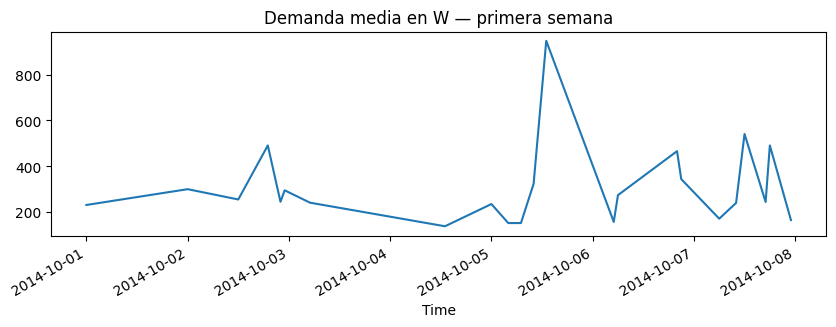

In [2]:
print("Dimensiones:", df.shape)
print(df.describe())
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
df['Aggregate'].iloc[:24*7].plot()
#Se tomaron las primeras 24×7 horas
plt.title('Demanda media en W — primera semana')
plt.show()

## 1) 📈 Regresión lineal

OLS -> MAE: 151.1137 | RMSE: 210.9044 | R²: -0.2818


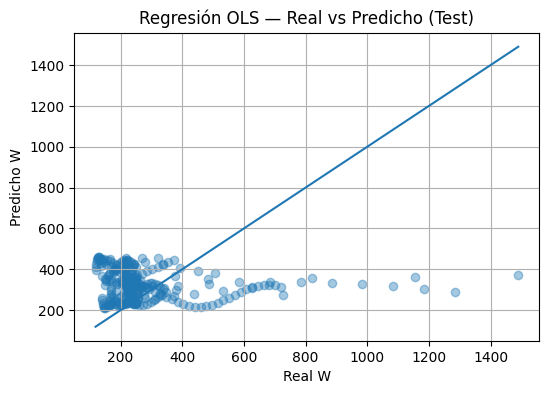

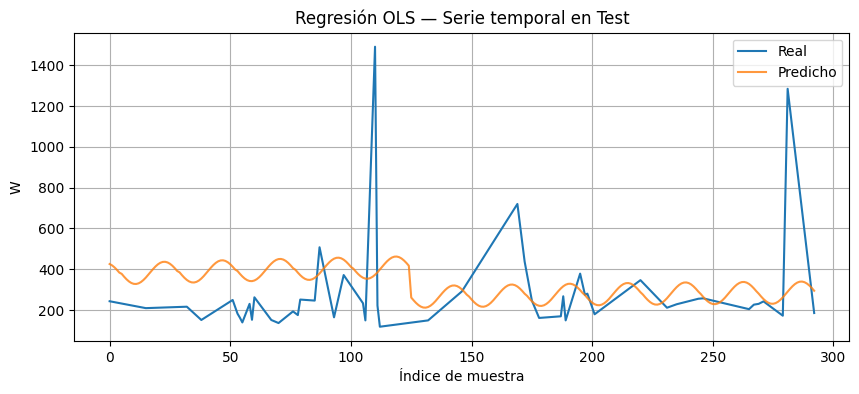

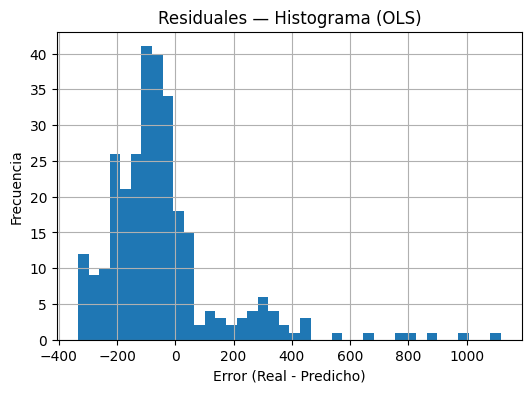

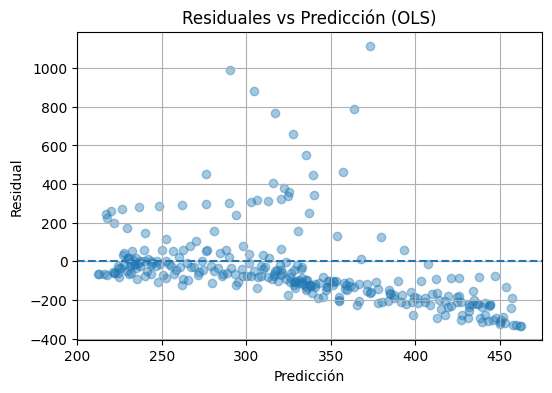

SGD RAW  -> MAE: 262.7655 | RMSE: 284.2521
SGD SCLD -> MAE: 179.5756 | RMSE: 222.0554


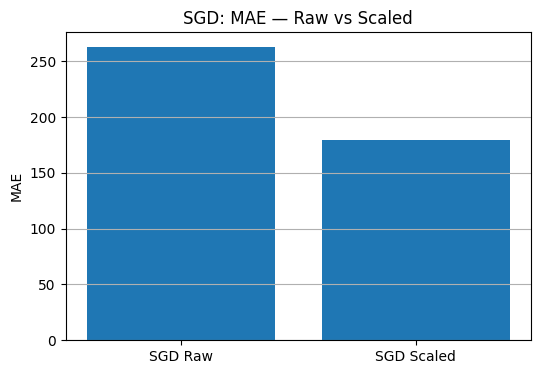

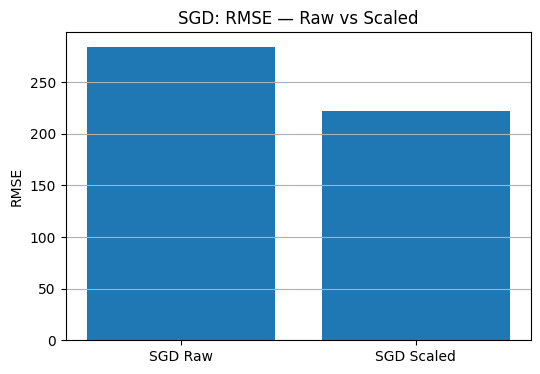

=== RESUMEN SPLIT TEMPORAL ===
Train: 2014-10-01 00:00:05 → 2014-11-18 18:00:05  |  Total: 1171 muestras  (~48.8 días)
Test : 2014-11-18 19:00:05 → 2014-11-30 23:00:05  |  Total: 293 muestras  (~12.2 días)


In [3]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ====== tus features (sin cambios) ======
work = df.copy().reset_index()
work['hora'] = work['Time'].dt.hour
work['dow'] = work['Time'].dt.dayofweek
work['dia_ano'] = work['Time'].dt.dayofyear
work['sin_hora'] = np.sin(2*np.pi*work['hora']/24)
work['cos_hora'] = np.cos(2*np.pi*work['hora']/24)
work['sin_dia']  = np.sin(2*np.pi*work['dia_ano']/365)
work['cos_dia']  = np.cos(2*np.pi*work['dia_ano']/365)

X = work[['sin_hora','cos_hora','sin_dia','cos_dia','dow']].values
y = work['Aggregate'].values

# Split temporal 80/20
cut = int(len(X)*0.8)
X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

# ====== Modelo base: Regresión Lineal (OLS) ======
lin = LinearRegression().fit(X_train, y_train)
y_pred = lin.predict(X_test)

mae_lin  = mean_absolute_error(y_test, y_pred)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred))
r2_lin   = r2_score(y_test, y_pred)

print(f"OLS -> MAE: {mae_lin:.4f} | RMSE: {rmse_lin:.4f} | R²: {r2_lin:.4f}")

# --- Gráfico 1: Real vs Predicho (con diagonal) ---
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.4)
_min, _max = np.min([y_test, y_pred]), np.max([y_test, y_pred])
plt.plot([_min, _max], [_min, _max])  # diagonal y=x
plt.xlabel('Real W'); plt.ylabel('Predicho W')
plt.title('Regresión OLS — Real vs Predicho (Test)')
plt.grid(True); plt.show()

# --- Gráfico 2: Serie temporal Real vs Predicho (tramo test) ---
plt.figure(figsize=(10,4))
plt.plot(y_test, label='Real')
plt.plot(y_pred, label='Predicho', alpha=0.8)
plt.title('Regresión OLS — Serie temporal en Test')
plt.xlabel('Índice de muestra'); plt.ylabel('W')
plt.legend(); plt.grid(True); plt.show()

# --- Gráfico 3: Residuales (histograma) ---
resid = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(resid, bins=40)
plt.title('Residuales — Histograma (OLS)')
plt.xlabel('Error (Real - Predicho)'); plt.ylabel('Frecuencia')
plt.grid(True); plt.show()

# --- Gráfico 4: Residuales vs Predicción ---
plt.figure(figsize=(6,4))
plt.scatter(y_pred, resid, alpha=0.4)
plt.axhline(0, linestyle='--')
plt.title('Residuales vs Predicción (OLS)')
plt.xlabel('Predicción'); plt.ylabel('Residual')
plt.grid(True); plt.show()

# ====== Importancia de normalizar: SGD raw vs scaled ======
sc = StandardScaler()
X_train_s, X_test_s = sc.fit_transform(X_train), sc.transform(X_test)

sgd_raw = SGDRegressor(max_iter=2000, tol=1e-3, random_state=0).fit(X_train,  y_train)
sgd_scl = SGDRegressor(max_iter=2000, tol=1e-3, random_state=0).fit(X_train_s, y_train)

pred_raw = sgd_raw.predict(X_test)
pred_scl = sgd_scl.predict(X_test_s)

mae_raw  = mean_absolute_error(y_test, pred_raw)
rmse_raw = np.sqrt(mean_squared_error(y_test, pred_raw))
mae_scl  = mean_absolute_error(y_test, pred_scl)
rmse_scl = np.sqrt(mean_squared_error(y_test, pred_scl))

print(f"SGD RAW  -> MAE: {mae_raw:.4f} | RMSE: {rmse_raw:.4f}")
print(f"SGD SCLD -> MAE: {mae_scl:.4f} | RMSE: {rmse_scl:.4f}")

# --- Barras MAE raw vs scaled ---
plt.figure(figsize=(6,4))
plt.bar(['SGD Raw','SGD Scaled'], [mae_raw, mae_scl])
plt.title('SGD: MAE — Raw vs Scaled'); plt.ylabel('MAE')
plt.grid(True, axis='y'); plt.show()

# --- Barras RMSE raw vs scaled ---
plt.figure(figsize=(6,4))
plt.bar(['SGD Raw','SGD Scaled'], [rmse_raw, rmse_scl])
plt.title('SGD: RMSE — Raw vs Scaled'); plt.ylabel('RMSE')
plt.grid(True, axis='y'); plt.show()

# ================== Info sobre el split temporal ==================
# Recordemos que 'work' tiene la columna Time ya lista
fechas = work['Time']

train_fechas = fechas[:cut]
test_fechas  = fechas[cut:]

print("=== RESUMEN SPLIT TEMPORAL ===")
print(f"Train: {train_fechas.min()} → {train_fechas.max()}  |  Total: {len(train_fechas)} muestras  (~{len(train_fechas)/24:.1f} días)")
print(f"Test : {test_fechas.min()} → {test_fechas.max()}  |  Total: {len(test_fechas)} muestras  (~{len(test_fechas)/24:.1f} días)")

## 2) 🤖 MLP — Próxima hora

=== SPLIT TEMPORAL (MLP features) ===
Train: 2014-10-01 00:00:05 → 2014-11-18 18:00:05  | muestras=1171 (~48.8 días)
Test : 2014-11-18 19:00:05  → 2014-11-30 23:00:05   | muestras=293 (~12.2 días)
RAW  -> MAE: 284.4301 | RMSE: 319.7585 | R²: -1.9464
SCLD -> MAE: 149.7425   | RMSE: 233.8120   | R²: -0.5754


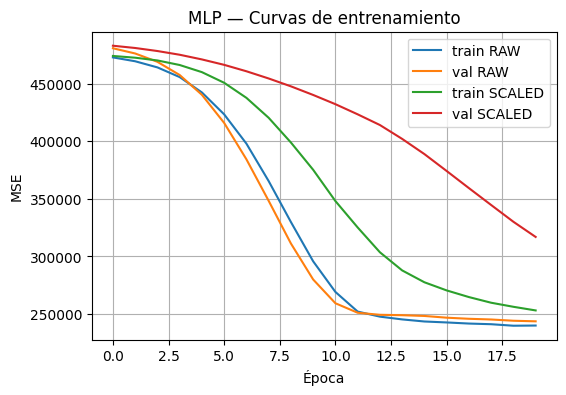

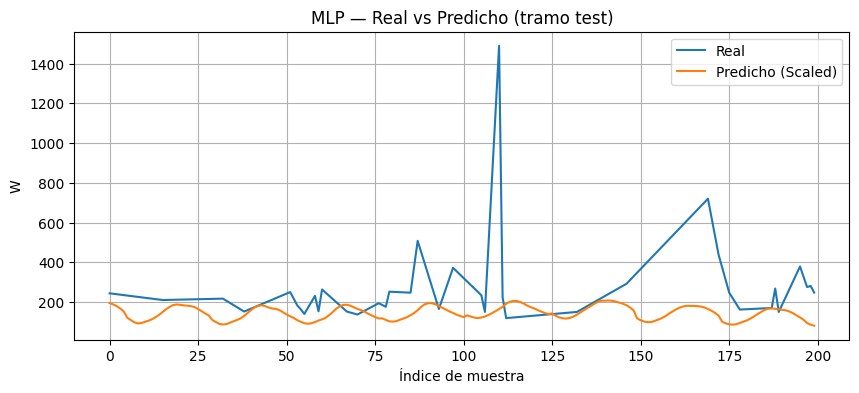

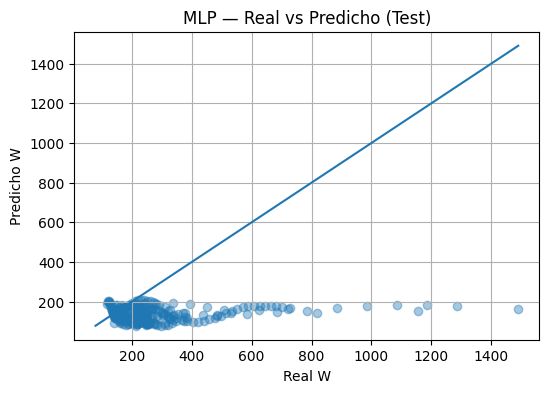

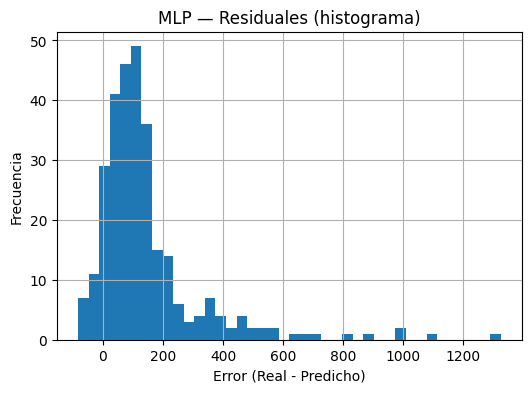

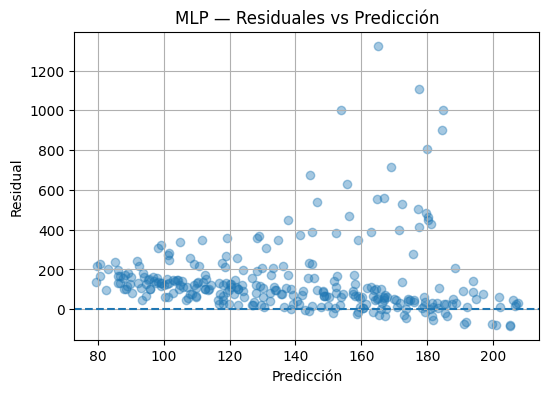

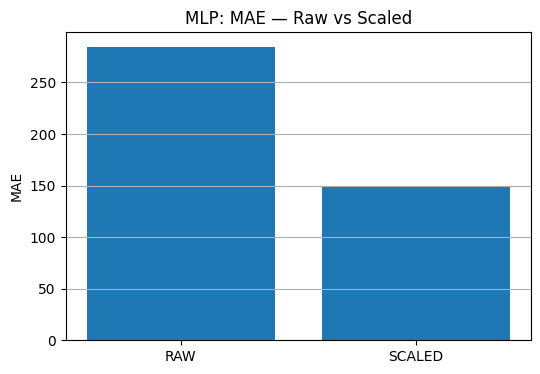

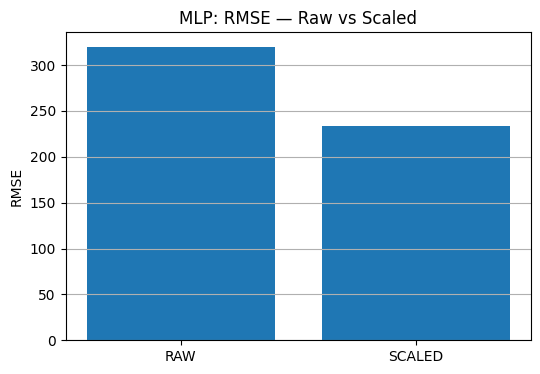

In [5]:
# ============ MLP con el MISMO split que la regresión lineal (80/20 temporal) ============
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras

def _clean(s): return str(s).replace("\ufeff","").replace("\xa0"," ").strip()

def _ensure_feature_split_from_df(df):
    """Crea features calendarias y split 80/20 temporal tal como en la regresión lineal."""
    d0 = df.copy()
    d0.columns = [_clean(c) for c in d0.columns]

    # Time como columna
    if d0.index.name is not None and _clean(d0.index.name).lower() in {"time","fecha","datetime","timestamp","date"}:
        d0 = d0.reset_index()

    lower = {c.lower(): c for c in d0.columns}
    tcol = "Time" if "Time" in d0.columns else next((lower[k] for k in ["time","fecha","datetime","timestamp","date"] if k in lower), None)
    ycol = "Aggregate" if "Aggregate" in d0.columns else next((lower[k] for k in ["aggregate","consumo","consumption","energy","kwh"] if k in lower), None)
    assert tcol and ycol, f"No encuentro columnas Time/Aggregate. Columnas: {list(d0.columns)}"

    work = d0[[tcol, ycol]].rename(columns={tcol:"Time", ycol:"Aggregate"}).copy()
    work["Time"] = pd.to_datetime(work["Time"], errors="coerce", infer_datetime_format=True)
    work = work.dropna(subset=["Time"]).sort_values("Time").reset_index(drop=True)

    # features idénticas a tu regresión
    work['hora']    = work['Time'].dt.hour
    work['dow']     = work['Time'].dt.dayofweek
    work['dia_ano'] = work['Time'].dt.dayofyear
    work['sin_hora'] = np.sin(2*np.pi*work['hora']/24)
    work['cos_hora'] = np.cos(2*np.pi*work['hora']/24)
    work['sin_dia']  = np.sin(2*np.pi*work['dia_ano']/365)
    work['cos_dia']  = np.cos(2*np.pi*work['dia_ano']/365)

    X = work[['sin_hora','cos_hora','sin_dia','cos_dia','dow']].values
    y = work['Aggregate'].values.astype(float)

    cut = int(len(X)*0.8)
    X_train, X_test = X[:cut], X[cut:]
    y_train, y_test = y[:cut], y[cut:]

    # guardar también las fechas para el resumen
    fechas = work['Time']
    return X_train, X_test, y_train, y_test, cut, fechas

# ---------- 1) Garantizar X_train/X_test con el mismo split de la regresión ----------
need_build = True
if 'X_train' in globals() and 'X_test' in globals() and 'y_train' in globals() and 'y_test' in globals():
    # Si ya existen y parecen de features (5 columnas), los reutilizamos
    if isinstance(X_train, np.ndarray) and X_train.ndim==2 and X_train.shape[1] == 5:
        need_build = False

if need_build:
    X_train, X_test, y_train, y_test, cut, fechas = _ensure_feature_split_from_df(df)
else:
    # Si los tenías, intentamos reconstruir 'fechas' para el resumen
    try:
        # Si conservaste 'work' en tu cuaderno original
        fechas = work['Time']
        cut = len(X_train)
    except Exception:
        # fallback desde df
        dtmp = df.copy()
        if 'Time' in dtmp.columns:
            fechas = pd.to_datetime(dtmp['Time'], errors="coerce")
        else:
            fechas = pd.to_datetime(dtmp.index)
        fechas = fechas.sort_values().reset_index(drop=True)
        cut = len(X_train)

# ---------- 2) Resumen de fechas del split ----------
def _print_split_dates(idx, cut):
    if idx is None or len(idx)==0: return
    train_idx = idx.iloc[:cut]
    test_idx  = idx.iloc[cut:]
    print("=== SPLIT TEMPORAL (MLP features) ===")
    print(f"Train: {train_idx.min()} → {train_idx.max()}  | muestras={len(train_idx)} (~{len(train_idx)/24:.1f} días)")
    print(f"Test : {test_idx.min()}  → {test_idx.max()}   | muestras={len(test_idx)} (~{len(test_idx)/24:.1f} días)")

_print_split_dates(fechas, cut)

# ---------- 3) MLP RAW vs SCALED (misma arquitectura) ----------
input_dim = X_train.shape[1]

# RAW
model_raw = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])
model_raw.compile(optimizer='adam', loss='mse')
hist_raw = model_raw.fit(X_train, y_train, validation_split=0.25, epochs=20, batch_size=64, verbose=0)
y_pred_raw = model_raw.predict(X_test, verbose=0).ravel()

# SCALED
sc = StandardScaler()
X_train_s = sc.fit_transform(X_train)
X_test_s  = sc.transform(X_test)

model_s = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])
model_s.compile(optimizer='adam', loss='mse')
hist_s = model_s.fit(X_train_s, y_train, validation_split=0.25, epochs=20, batch_size=64, verbose=0)
y_pred_s = model_s.predict(X_test_s, verbose=0).ravel()

# ---------- 4) Métricas y gráficos ----------
def _metrics(y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    r2 = r2_score(y_true, y_hat)
    return mae, rmse, r2

mae_raw, rmse_raw, r2_raw = _metrics(y_test, y_pred_raw)
mae_s,   rmse_s,   r2_s   = _metrics(y_test, y_pred_s)

print(f"RAW  -> MAE: {mae_raw:.4f} | RMSE: {rmse_raw:.4f} | R²: {r2_raw:.4f}")
print(f"SCLD -> MAE: {mae_s:.4f}   | RMSE: {rmse_s:.4f}   | R²: {r2_s:.4f}")

# Curvas de pérdida
plt.figure(figsize=(6,4))
plt.plot(hist_raw.history['loss'], label='train RAW')
plt.plot(hist_raw.history['val_loss'], label='val RAW')
plt.plot(hist_s.history['loss'], label='train SCALED')
plt.plot(hist_s.history['val_loss'], label='val SCALED')
plt.title('MLP — Curvas de entrenamiento'); plt.xlabel('Época'); plt.ylabel('MSE')
plt.legend(); plt.grid(True); plt.show()

# Serie temporal en test (primeros k puntos)
k = min(200, len(y_test))
plt.figure(figsize=(10,4))
plt.plot(y_test[:k], label='Real')
plt.plot(y_pred_s[:k], label='Predicho (Scaled)')
plt.title('MLP — Real vs Predicho (tramo test)')
plt.xlabel('Índice de muestra'); plt.ylabel('W')
plt.legend(); plt.grid(True); plt.show()

# Dispersión Real vs Predicho
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_s, alpha=0.4)
_min, _max = np.min([y_test, y_pred_s]), np.max([y_test, y_pred_s])
plt.plot([_min, _max], [_min, _max])
plt.xlabel('Real W'); plt.ylabel('Predicho W'); plt.title('MLP — Real vs Predicho (Test)')
plt.grid(True); plt.show()

# Residuales
resid = y_test - y_pred_s
plt.figure(figsize=(6,4))
plt.hist(resid, bins=40)
plt.title('MLP — Residuales (histograma)')
plt.xlabel('Error (Real - Predicho)'); plt.ylabel('Frecuencia')
plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_pred_s, resid, alpha=0.4)
plt.axhline(0, linestyle='--')
plt.title('MLP — Residuales vs Predicción')
plt.xlabel('Predicción'); plt.ylabel('Residual')
plt.grid(True); plt.show()

# Barras RAW vs SCALED
plt.figure(figsize=(6,4))
plt.bar(['RAW','SCALED'], [mae_raw, mae_s])
plt.title('MLP: MAE — Raw vs Scaled'); plt.ylabel('MAE')
plt.grid(True, axis='y'); plt.show()

plt.figure(figsize=(6,4))
plt.bar(['RAW','SCALED'], [rmse_raw, rmse_s])
plt.title('MLP: RMSE — Raw vs Scaled'); plt.ylabel('RMSE')
plt.grid(True, axis='y'); plt.show()

/tmp/ipython-input-485196243.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y = s.resample('H').mean()


MLP (lags+MA) -> MAE 54.33 | RMSE 115.87 | R² 0.6515


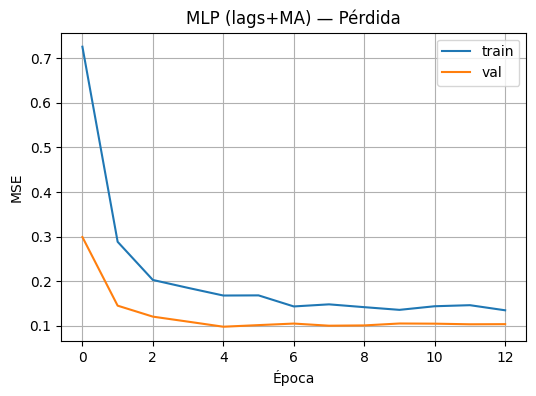

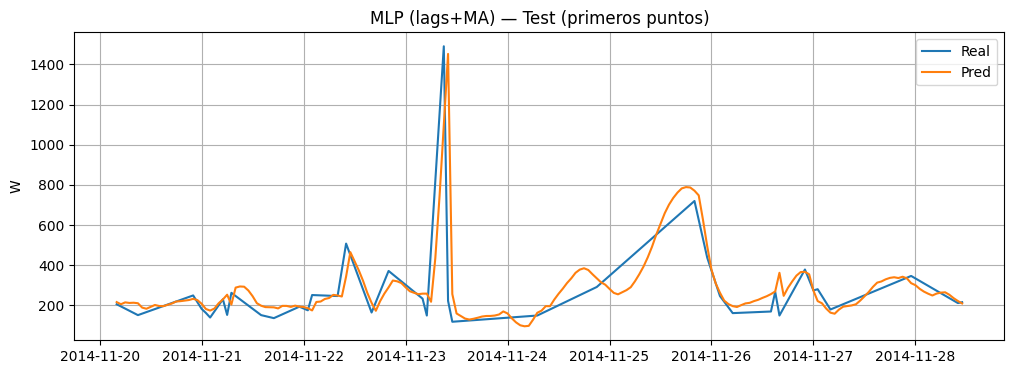

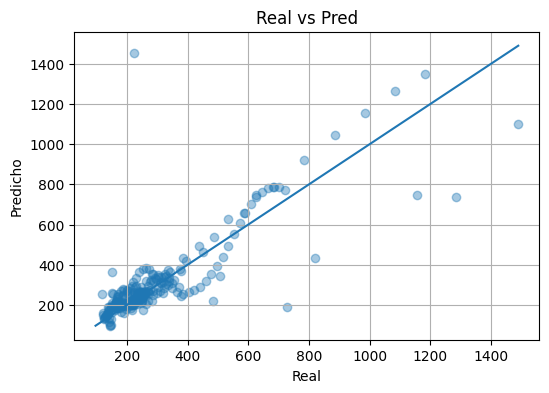

=== SPLIT TEMPORAL (MLP con features) ===
Train: 2014-10-08 00:00:00 → 2014-11-20 03:00:00  |  Total: 1036 muestras  (~43.2 días)
Test : 2014-11-20 04:00:00  → 2014-11-30 23:00:00   |  Total: 260 muestras  (~10.8 días)


In [6]:
# ================== MLP con LAGS y MEDIAS MÓVILES (versión robusta) ==================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras
import tensorflow as tf
import os, random

# Reproducibilidad (opcional)
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

def build_lag_features(df):
    w = df.copy()
    # Normaliza nombres (evita espacios ocultos)
    w.columns = w.columns.str.strip()

    # --- 1) Asegurar índice datetime ---
    # Si existe 'Time' (o variantes) como columna, úsala; si no, intenta con el índice.
    time_candidates = [c for c in w.columns
                       if str(c).strip().lower() in ('time', 'timestamp', 'datetime', 'date', 'datetime_utc')]
    if time_candidates:
        tcol = time_candidates[0]
        w[tcol] = pd.to_datetime(w[tcol], errors='coerce')
        w = w.dropna(subset=[tcol]).sort_values(tcol).set_index(tcol)
    elif isinstance(w.index, pd.DatetimeIndex):
        # ya viene indexado por tiempo
        w = w.sort_index()
    else:
        raise ValueError("No se encontró columna de tiempo ('Time', 'Timestamp', etc.) ni índice datetime.")

    # --- 2) Serie objetivo: 'Aggregate' (RESAMPLE HORARIO) ---
    tgt_candidates = [c for c in w.columns if str(c).strip().lower() == 'aggregate']
    if not tgt_candidates:
        raise ValueError("No se encontró la columna 'Aggregate' en el DataFrame.")
    tgt = tgt_candidates[0]

    s = pd.to_numeric(w[tgt], errors='coerce')

    # Si tu muestra es sub-horaria, tomamos promedio por hora; si ya es horaria, queda igual.
    y = s.resample('H').mean()

    # Interpola en el tiempo y completa extremos
    y = y.interpolate('time').bfill().ffill()
    w = y.to_frame('y')

    # --- 3) Calendarios (cíclicos) ---
    w['hora'] = w.index.hour
    w['dow']  = w.index.dayofweek
    w['sin_hora'] = np.sin(2*np.pi*w['hora']/24)
    w['cos_hora'] = np.cos(2*np.pi*w['hora']/24)

    # --- 4) Lags típicos y medias móviles ---
    w['lag1']   = w['y'].shift(1)
    w['lag24']  = w['y'].shift(24)
    w['lag168'] = w['y'].shift(168)

    w['ma24']   = w['y'].rolling(24,  min_periods=1).mean()
    w['ma168']  = w['y'].rolling(168, min_periods=1).mean()

    # Quita filas inválidas por lags
    w = w.dropna()
    return w

# --------- Construcción de features ---------
w = build_lag_features(df)

feat_cols = ['sin_hora','cos_hora','dow','lag1','lag24','lag168','ma24','ma168']
X = w[feat_cols].values.astype(float)
y = w['y'].values.astype(float)

# Split temporal 80/20 (cronológico)
cut = int(len(X)*0.8)
X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]
idx_train, idx_test = w.index[:cut], w.index[cut:]

# Escalado X e Y (z-score)
sx = StandardScaler()
sy = StandardScaler()
X_train_s = sx.fit_transform(X_train)
X_test_s  = sx.transform(X_test)
y_train_s = sy.fit_transform(y_train.reshape(-1,1)).ravel()

# --------- Modelo MLP ---------
model = keras.Sequential([
    keras.layers.Input(shape=(X_train_s.shape[1],)),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    keras.layers.Dropout(0.20),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    keras.layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')

cb = [
    keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-5)
]

hist = model.fit(X_train_s, y_train_s, validation_split=0.25,
                 epochs=100, batch_size=128, callbacks=cb, verbose=0)

# Predicción y desescalado
y_pred_s = model.predict(X_test_s, verbose=0).ravel()
y_pred = sy.inverse_transform(y_pred_s.reshape(-1,1)).ravel()

# --------- Métricas ---------
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f"MLP (lags+MA) -> MAE {mae:.2f} | RMSE {rmse:.2f} | R² {r2:.4f}")

# --------- Gráficos ---------
plt.figure(figsize=(6,4))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('MLP (lags+MA) — Pérdida'); plt.xlabel('Época'); plt.ylabel('MSE')
plt.legend(); plt.grid(True); plt.show()

k = min(200, len(y_test))
plt.figure(figsize=(12,4))
plt.plot(idx_test[:k], y_test[:k], label='Real')
plt.plot(idx_test[:k], y_pred[:k], label='Pred')
plt.title('MLP (lags+MA) — Test (primeros puntos)'); plt.ylabel('W')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.4)
a, b = np.min([y_test, y_pred]), np.max([y_test, y_pred])
plt.plot([a,b], [a,b])
plt.title('Real vs Pred'); plt.xlabel('Real'); plt.ylabel('Predicho')
plt.grid(True); plt.show()

# ================== Info sobre el split temporal para MLP ==================
# Usar SIEMPRE el índice del dataset procesado 'w' (alineado con X/y)
fechas = w.index
train_fechas = fechas[:cut]
test_fechas  = fechas[cut:]
print("=== SPLIT TEMPORAL (MLP con features) ===")
print(f"Train: {train_fechas.min()} → {train_fechas.max()}  |  Total: {len(train_fechas)} muestras  (~{len(train_fechas)/24:.1f} días)")
print(f"Test : {test_fechas.min()}  → {test_fechas.max()}   |  Total: {len(test_fechas)} muestras  (~{len(test_fechas)/24:.1f} días)")

# (Opcional) Si trabajas con un esquema de ventanas distinto:
if 'cut_v' in globals() and 'win' in globals():
    fechas_eff = fechas[win:]   # se pierden las primeras "win" horas por ventanas
    train_fechas = fechas_eff[:cut_v]
    test_fechas  = fechas_eff[cut_v:]
    print("\n=== SPLIT TEMPORAL (MLP con ventanas) ===")
    print(f"Train: {train_fechas.min()} → {train_fechas.max()}  |  Total: {len(train_fechas)} muestras  (~{len(train_fechas)/24:.1f} días)")
    print(f"Test : {test_fechas.min()}  → {test_fechas.max()}   |  Total: {len(test_fechas)} muestras  (~{len(test_fechas)/24:.1f} días)")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


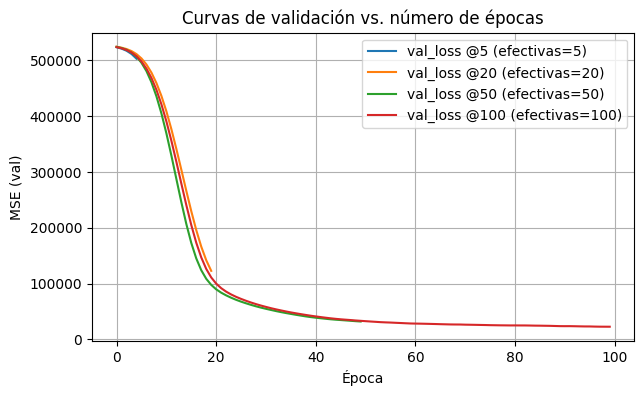

Resultados en TEST (con EarlyStopping y entradas escaladas):
Epocas | Epocas_efectivas |    MAE    |    RMSE   |    R^2
     5 |                5 | 272.9937 | 335.1780 | -1.9162
    20 |               20 | 113.0374 | 155.2962 |  0.3740
    50 |               50 |  83.7412 | 127.1764 |  0.5802
   100 |              100 |  64.3850 | 115.9665 |  0.6509
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


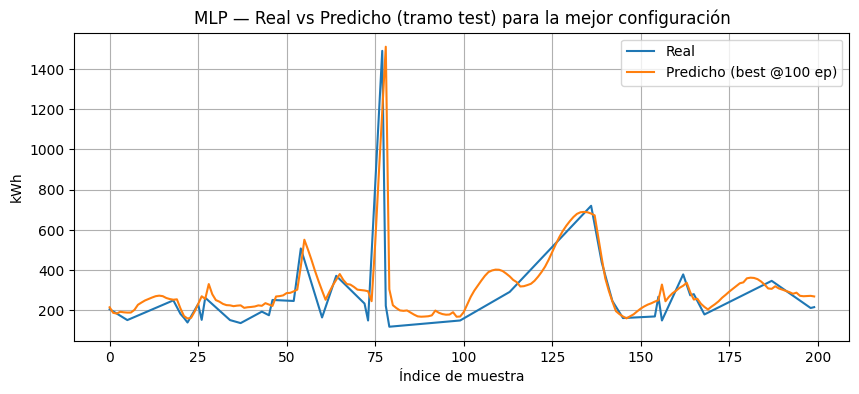

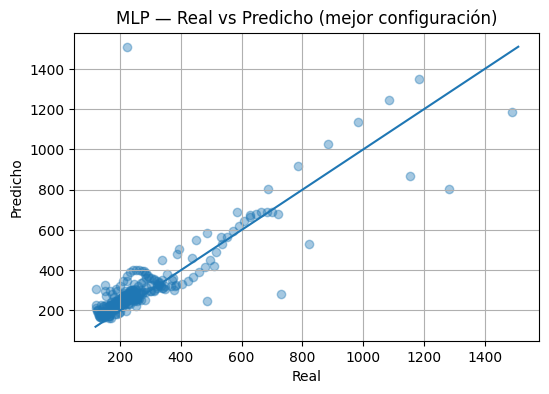

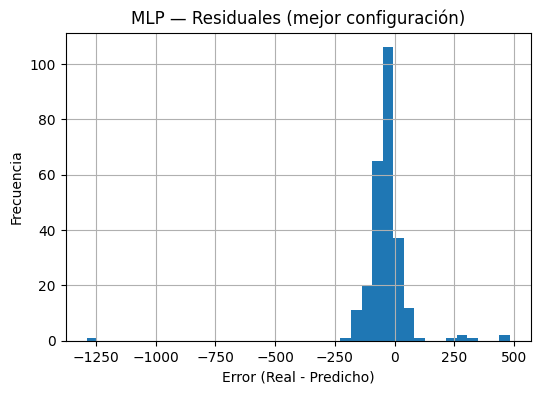

In [7]:
# ====== Experimentos con número de épocas (con EarlyStopping) ======*
import numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras

# Usaremos la variante con entradas ESCALADAS (suele comportarse mejor)
if 'X_train_s' not in globals():
    sc = StandardScaler()
    X_train_s = sc.fit_transform(X_train)
    X_test_s  = sc.transform(X_test)

def build_mlp(input_dim: int):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,                 # espera 5 épocas sin mejora
    restore_best_weights=True   # recupera los mejores pesos (val_loss mínimo)
)

epochs_list = [5, 20, 50, 100]
histories = {}
metrics_table = []

for n_epochs in epochs_list:
    model_ep = build_mlp(X_train_s.shape[1])
    hist = model_ep.fit(
        X_train_s, y_train,
        validation_split=0.25,
        epochs=n_epochs,
        batch_size=64,
        verbose=0,
        callbacks=[early_stop]
    )
    histories[n_epochs] = hist.history

    # Predicción en test y métricas
    y_pred = model_ep.predict(X_test_s).ravel()
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # compatibilidad amplia
    r2   = r2_score(y_test, y_pred)
    metrics_table.append((n_epochs, len(hist.history['loss']), mae, rmse, r2))

# ====== Curvas de entrenamiento (val_loss) comparando épocas ======
plt.figure(figsize=(7,4))
for n_epochs in epochs_list:
    val_loss = histories[n_epochs]['val_loss']
    plt.plot(val_loss, label=f'val_loss @{n_epochs} (efectivas={len(val_loss)})')
plt.xlabel('Época')
plt.ylabel('MSE (val)')
plt.title('Curvas de validación vs. número de épocas')
plt.legend()
plt.grid(True)
plt.show()

# ====== Tabla simple de métricas (Test) por configuración de épocas ======
print("Resultados en TEST (con EarlyStopping y entradas escaladas):")
print("Epocas | Epocas_efectivas |    MAE    |    RMSE   |    R^2")
for ep, eff, mae, rmse, r2 in metrics_table:
    print(f"{ep:6d} | {eff:16d} | {mae:8.4f} | {rmse:8.4f} | {r2:7.4f}")

# ====== (Opcional) Gráfico Real vs Predicho para la mejor configuración ======
# Elegimos la configuración con menor RMSE:
best_idx = int(np.argmin([row[3] for row in metrics_table]))
best_epochs = metrics_table[best_idx][0]

# Reentrenamos el mejor para graficar (o podrías guardar el modelo durante el bucle)
model_best = build_mlp(X_train_s.shape[1])
_ = model_best.fit(
    X_train_s, y_train,
    validation_split=0.25,
    epochs=best_epochs,
    batch_size=64,
    verbose=0,
    callbacks=[early_stop]
)
y_pred_best = model_best.predict(X_test_s).ravel()

k = min(200, len(y_test))
plt.figure(figsize=(10,4))
plt.plot(y_test[:k], label='Real')
plt.plot(y_pred_best[:k], label=f'Predicho (best @{best_epochs} ep)')
plt.title('MLP — Real vs Predicho (tramo test) para la mejor configuración')
plt.xlabel('Índice de muestra'); plt.ylabel('kWh')
plt.legend(); plt.grid(True); plt.show()

# Dispersión y residuales para la mejor configuración
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_best, alpha=0.4)
_min, _max = np.min([y_test, y_pred_best]), np.max([y_test, y_pred_best])
plt.plot([_min, _max], [_min, _max])
plt.xlabel('Real'); plt.ylabel('Predicho')
plt.title('MLP — Real vs Predicho (mejor configuración)')
plt.grid(True); plt.show()

resid = y_test - y_pred_best
plt.figure(figsize=(6,4))
plt.hist(resid, bins=40)
plt.title('MLP — Residuales (mejor configuración)')
plt.xlabel('Error (Real - Predicho)'); plt.ylabel('Frecuencia')
plt.grid(True); plt.show()

## 3) ⏳ Series de tiempo: ARIMA, Prophet y LSTM

In [8]:
print(df.columns.tolist())
df.head()

['Unix', 'Aggregate', 'Appliance1', 'Appliance2', 'Appliance3', 'Appliance4', 'Appliance5', 'Appliance6', 'Appliance7', 'Appliance8', 'Appliance9', 'Issues']


,Unix,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9,Issues
Time,,,,,,,,,,,,
2014-10-01 00:00:05,1.412122e+09,231.000,89.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,45.0,0.0
2014-10-01 01:00:05,NaN,233.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-01 02:00:05,NaN,236.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-01 03:00:05,NaN,239.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-01 04:00:05,NaN,242.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipython-input-4285096804.py:32: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d0["Time"] = pd.to_datetime(d0["Time"], errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-4285096804.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ser = pd.to_numeric(d0["Aggregate"], errors="coerce").asfreq("H")


Rango temporal: 2014-10-01 00:00:05 → 2014-11-30 23:00:05 | Filas: 1464


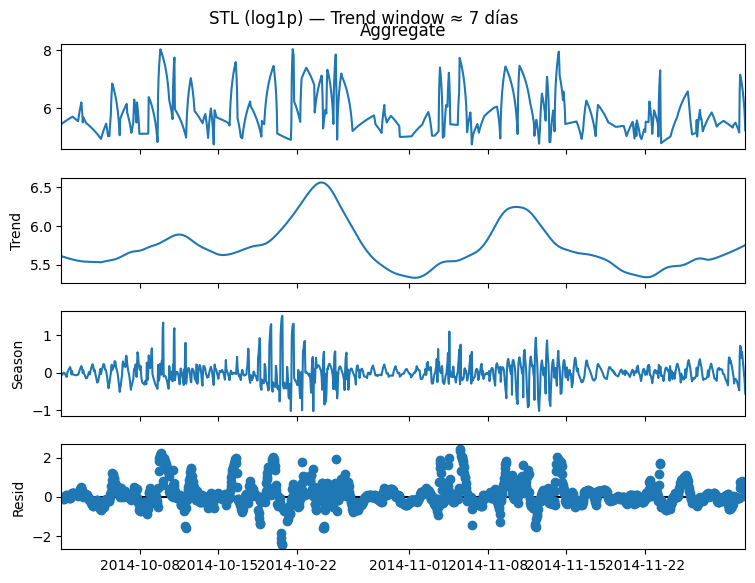

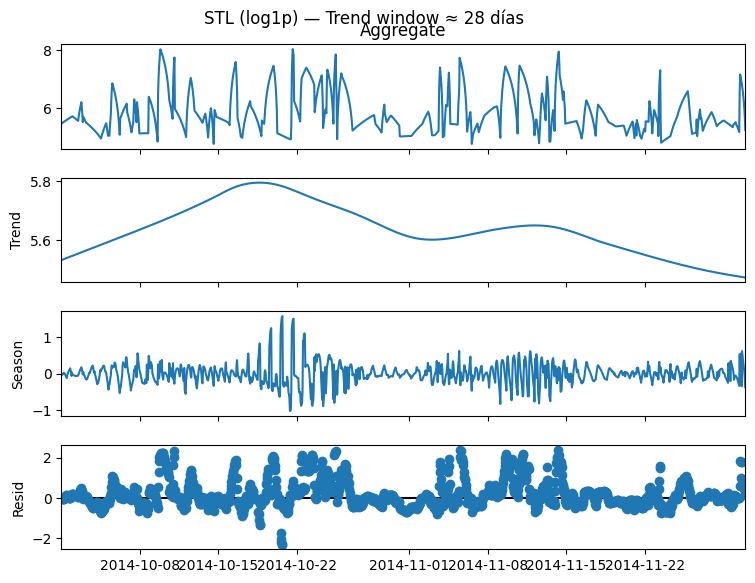

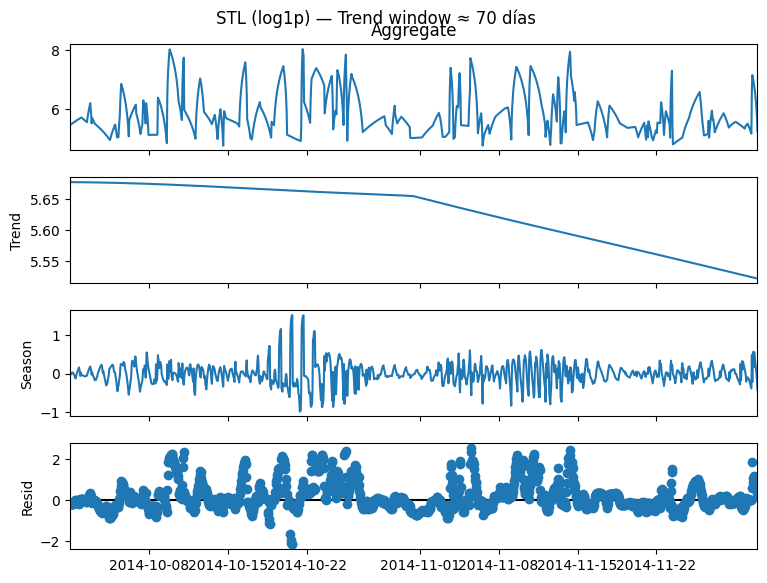

Train: 2014-10-01 00:00:05 → 2014-11-23 23:00:05 | 1296
Test : 2014-11-24 00:00:05 → 2014-11-30 23:00:05 | 168
ℹ️ pmdarima no disponible/compatible, usaré grid con statsmodels.
Detalle: No module named 'pmdarima'
Grid ARIMA → orden seleccionado: (1, 0, 3) | AIC: -460.30
ARIMA -> MAE 0.3968 | RMSE 0.4614


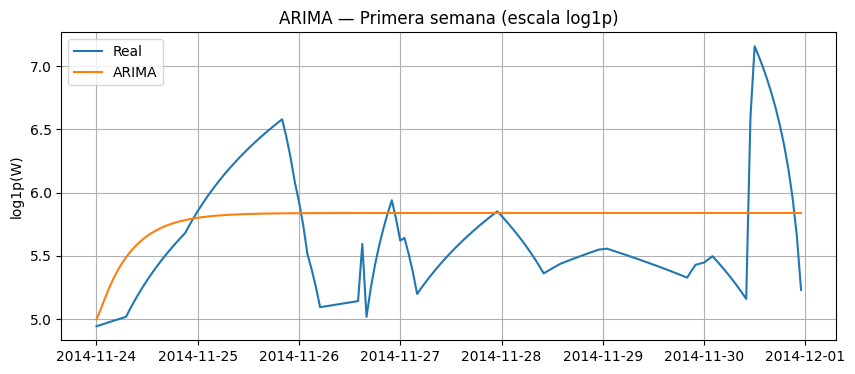

DEBUG:cmdstanpy:input tempfile: /tmp/tmprqsk8e4s/5hihnkey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprqsk8e4s/tpyuzolc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2908', 'data', 'file=/tmp/tmprqsk8e4s/5hihnkey.json', 'init=/tmp/tmprqsk8e4s/tpyuzolc.json', 'output', 'file=/tmp/tmprqsk8e4s/prophet_modelfpuzak0q/prophet_model-20250824230031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:00:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:00:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet -> MAE 0.7236 | RMSE 0.8547


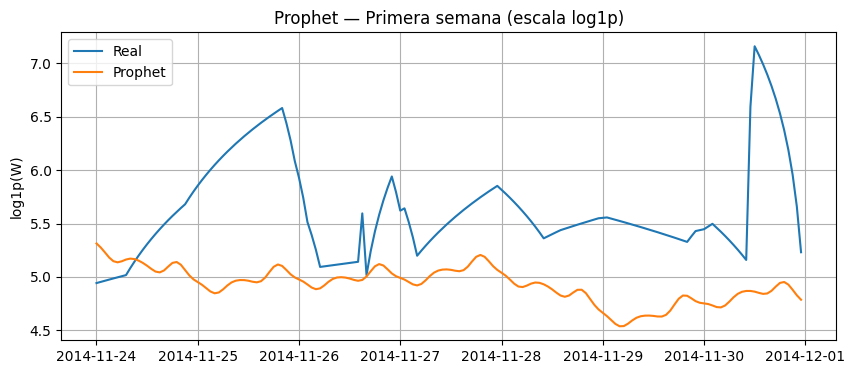

LSTM -> MAE 1.5552 | RMSE 1.6391


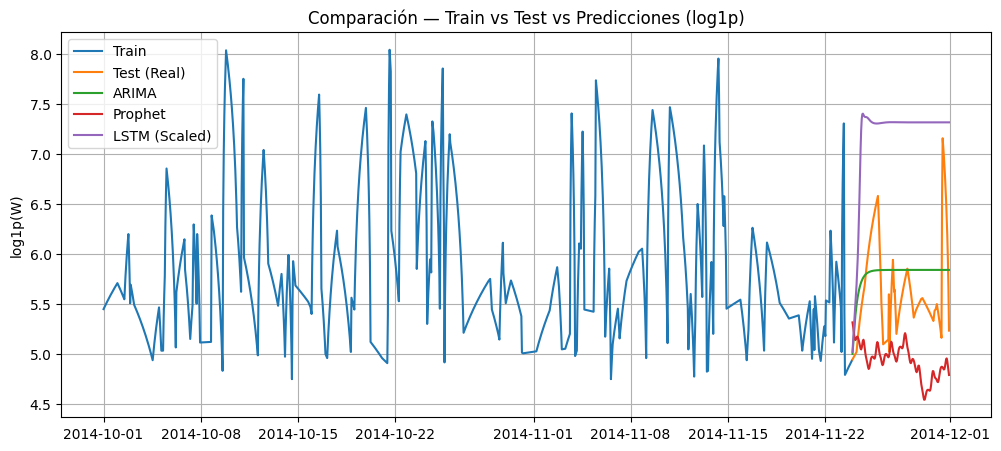


=== Métricas en escala original (W) ===
ARIMA   -> MAE 134.92 | RMSE 190.13
Prophet -> MAE 179.96 | RMSE 263.78
LSTM    -> MAE 1098.17 | RMSE 1148.82


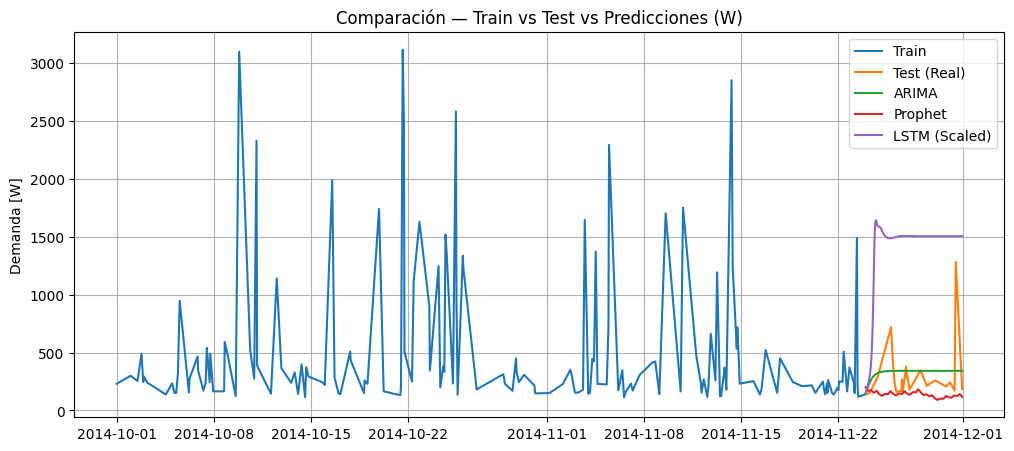


=== Comparativa en W (MAE / RMSE) ===
ARIMA   -> MAE:   134.92 | RMSE:   190.13
Prophet -> MAE:   179.96 | RMSE:   263.78
LSTM    -> MAE:  1098.17 | RMSE:  1148.82


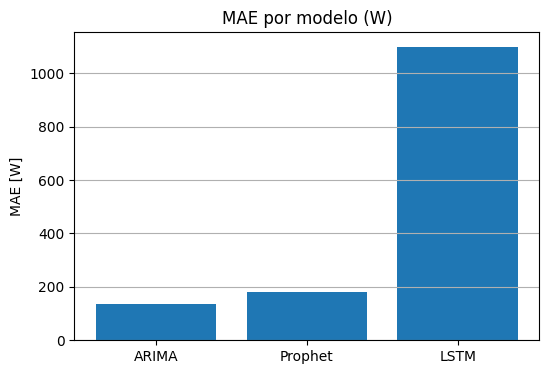

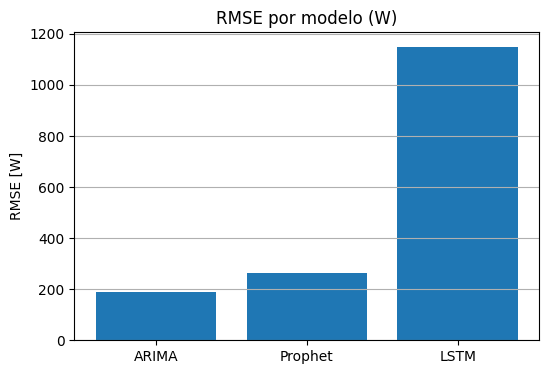

In [9]:
# ================== BLOQUE COMPLETO CON FALLBACK ARIMA ==================
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import tensorflow as tf
from tensorflow import keras

# ------------------------ 0) Preparar df_ts (si no existe) ------------------------
def _clean(s):
    return str(s).replace("\ufeff","").replace("\xa0"," ").strip()

if 'df_ts' not in globals():
    assert 'df' in globals() and isinstance(df, pd.DataFrame), \
        "No encuentro df_ts ni df. Carga tu CSV en 'df' antes de este bloque."
    d0 = df.copy()
    d0.columns = [_clean(c) for c in d0.columns]

    # si Time está en índice, pásalo a columna
    if d0.index.name is not None and _clean(d0.index.name).lower() in {"time","fecha","datetime","timestamp","date"}:
        d0 = d0.reset_index()

    lower = {c.lower(): c for c in d0.columns}
    time_col = "Time" if "Time" in d0.columns else next((lower[k] for k in ["time","fecha","datetime","timestamp","date"] if k in lower), None)
    agg_col  = "Aggregate" if "Aggregate" in d0.columns else next((lower[k] for k in ["aggregate","consumo","consumption","energy","kwh"] if k in lower), None)
    if time_col is None or agg_col is None:
        raise ValueError(f"No encuentro columnas tiempo/consumo en df. Columnas: {list(d0.columns)}")

    d0 = d0[[time_col, agg_col]].rename(columns={time_col:"Time", agg_col:"Aggregate"}).copy()
    d0["Time"] = pd.to_datetime(d0["Time"], errors="coerce", infer_datetime_format=True)
    d0 = d0.dropna(subset=["Time"]).sort_values("Time").set_index("Time")

    ser = pd.to_numeric(d0["Aggregate"], errors="coerce").asfreq("H")
    ser = ser.interpolate("time").bfill().ffill()
    df_ts = ser.to_frame(name="Aggregate")

print("Rango temporal:", df_ts.index.min(), "→", df_ts.index.max(), "| Filas:", len(df_ts))

# ------------------------ 1) STL en log1p con sensibilidad 7/28/70 ------------------------
series_raw = df_ts["Aggregate"].astype(float)
series = np.log1p(series_raw)  # estabiliza picos

for days in [7, 28, 70]:
    stl = STL(series, period=24, trend=days*24+1, robust=True).fit()
    fig = stl.plot(); fig.set_size_inches(8,6)
    fig.suptitle(f"STL (log1p) — Trend window ≈ {days} días")
    plt.show()

# ------------------------ 2) Split temporal: últimos 7 días como test ------------------------
horizon = 24*7
if len(series) <= horizon + 200:
    print("⚠️ Pocas filas para 7 días de test; el rendimiento puede ser débil.")
y_train, y_test = series.iloc[:-horizon], series.iloc[-horizon:]
print("Train:", y_train.index.min(), "→", y_train.index.max(), "|", len(y_train))
print("Test :", y_test.index.min(),  "→", y_test.index.max(),  "|", len(y_test))

# ------------------------ 3) ARIMA con fallback (auto_arima si disponible; si no, grid AIC) ------------------------
def arima_fallback_grid(y_train, p_list=(0,1,2,3), d_list=(0,1), q_list=(0,1,2,3)):
    best = {"aic": np.inf, "order": None, "model": None}
    for p in p_list:
        for d in d_list:
            for q in q_list:
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        m = ARIMA(y_train, order=(p,d,q)).fit()
                    if m.aic < best["aic"]:
                        best = {"aic": m.aic, "order": (p,d,q), "model": m}
                except Exception:
                    continue
    if best["model"] is None:
        raise RuntimeError("No se pudo ajustar ningún ARIMA en el grid.")
    return best

# Intentar auto_arima
use_pmd = False
try:
    from pmdarima import auto_arima
    use_pmd = True
except Exception as e:
    print("ℹ️ pmdarima no disponible/compatible, usaré grid con statsmodels.\nDetalle:", e)

if use_pmd:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model_arima = auto_arima(y_train, seasonal=False, stepwise=True, suppress_warnings=True)
    fc_arima = model_arima.predict(n_periods=len(y_test))
    best_order = model_arima.order
    print("auto_arima → orden seleccionado:", best_order)
else:
    best = arima_fallback_grid(y_train)
    best_order = best["order"]
    fc_arima = best["model"].forecast(steps=len(y_test))
    print(f"Grid ARIMA → orden seleccionado: {best_order} | AIC: {best['aic']:.2f}")

arima_mae  = mean_absolute_error(y_test, fc_arima)
arima_rmse = np.sqrt(mean_squared_error(y_test, fc_arima))
print(f"ARIMA -> MAE {arima_mae:.4f} | RMSE {arima_rmse:.4f}")

k = min(24*7, len(y_test))
plt.figure(figsize=(10,4))
plt.plot(y_test.index[:k], y_test.values[:k], label='Real')
plt.plot(y_test.index[:k], np.array(fc_arima)[:k], label='ARIMA')
plt.title('ARIMA — Primera semana (escala log1p)'); plt.ylabel('log1p(W)')
plt.legend(); plt.grid(True); plt.show()

# ------------------------ 4) Prophet (multiplicativa) ------------------------
train_df = y_train.reset_index(); train_df.columns = ['ds','y']
m = Prophet(daily_seasonality=True, weekly_seasonality=True,
            yearly_seasonality=False, seasonality_mode='multiplicative')
m.fit(train_df)
future = pd.DataFrame({'ds': y_test.index})
forecast = m.predict(future)
fc_prophet = forecast['yhat'].values

prophet_mae  = mean_absolute_error(y_test, fc_prophet)
prophet_rmse = np.sqrt(mean_squared_error(y_test, fc_prophet))
print(f"Prophet -> MAE {prophet_mae:.4f} | RMSE {prophet_rmse:.4f}")

plt.figure(figsize=(10,4))
plt.plot(y_test.index[:k], y_test.values[:k], label='Real')
plt.plot(y_test.index[:k], np.array(fc_prophet)[:k], label='Prophet')
plt.title('Prophet — Primera semana (escala log1p)'); plt.ylabel('log1p(W)')
plt.legend(); plt.grid(True); plt.show()

# --- LSTM (ventana 168) con predicción RECURSIVA, robusta a test cortos ---
def make_supervised(arr, win=24):
    X, y = [], []
    for i in range(len(arr)-win):
        X.append(arr[i:i+win]); y.append(arr[i+win])
    X = np.asarray(X)
    y = np.asarray(y)
    if X.ndim == 2:
        X = X[:, :, None]  # (n, win, 1)
    return X, y

win = 168  # 1 semana
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# Escalado solo con TRAIN (log1p ya aplicado arriba en 'series')
ytr_s = sc.fit_transform(y_train.values.reshape(-1,1)).ravel()

# Con TRAIN sí construimos supervisado para entrenar
Xtr, ytr = make_supervised(ytr_s, win)

# Modelo LSTM
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Input(shape=(win,1)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
_ = model.fit(Xtr, ytr, validation_split=0.2, epochs=50, batch_size=32, callbacks=[cb], verbose=0)

# >>> Predicción RECURSIVA en el HORIZONTE DE TEST <<<
# Partimos de la última ventana del TRAIN (escalada)
hist_vals_s = ytr_s[-win:].tolist()
preds_s = []
for _ in range(len(y_test)):
    x = np.array(hist_vals_s[-win:])[None, :, None]  # (1, win, 1)
    p = model.predict(x, verbose=0).ravel()[0]
    preds_s.append(p)
    hist_vals_s.append(p)

# Volver a la escala log1p y luego a kWh si lo necesitas más abajo
preds = sc.inverse_transform(np.array(preds_s).reshape(-1,1)).ravel()

# Métricas en escala log1p (comparando contra y_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error
lstm_mae  = mean_absolute_error(y_test, preds)
lstm_rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"LSTM -> MAE {lstm_mae:.4f} | RMSE {lstm_rmse:.4f}")

# Si más abajo calculas métricas en W:
# preds_orig = np.expm1(preds)
# lstm_mae_o  = mean_absolute_error(np.expm1(y_test), preds_orig)
# lstm_rmse_o = np.sqrt(mean_squared_error(np.expm1(y_test), preds_orig))

# ------------------------ helper para alinear predicciones con el índice ------------------------
def align_xy(idx_test, yhat):
    """Devuelve (x_alineado, y_alineado) con misma longitud."""
    yhat = np.asarray(yhat)
    n = min(len(idx_test), len(yhat))
    return idx_test[-n:], yhat[-n:]

# ------------------------ 6) Gráfico comparativo (escala log1p) ------------------------
plt.figure(figsize=(12,5))
plt.plot(y_train.index, y_train.values, label='Train')
plt.plot(y_test.index,  y_test.values,  label='Test (Real)')

x_ar, y_ar = align_xy(y_test.index, fc_arima)
plt.plot(x_ar, y_ar, label='ARIMA')

x_pr, y_pr = align_xy(y_test.index, fc_prophet)
plt.plot(x_pr, y_pr, label='Prophet')

x_lstm, y_lstm = align_xy(y_test.index, preds)  # <- ¡antes fallaba por win!
plt.plot(x_lstm, y_lstm, label='LSTM (Scaled)')

plt.title("Comparación — Train vs Test vs Predicciones (log1p)")
plt.ylabel('log1p(W)')
plt.legend(); plt.grid(True); plt.show()

# ------------------------ 7) Volver a escala original (kWh) + métricas ------------------------
y_train_orig = np.expm1(y_train)
y_test_orig  = np.expm1(y_test)
fc_arima_orig   = np.expm1(fc_arima)
fc_prophet_orig = np.expm1(fc_prophet)
preds_orig      = np.expm1(preds)

# Alinear para métricas en kWh
xa, ya = align_xy(y_test_orig.index, fc_arima_orig)
xp, yp = align_xy(y_test_orig.index, fc_prophet_orig)
xl, yl = align_xy(y_test_orig.index, preds_orig)

arima_mae_o  = mean_absolute_error(y_test_orig.loc[xa], ya)
arima_rmse_o = np.sqrt(mean_squared_error(y_test_orig.loc[xa], ya))

prophet_mae_o  = mean_absolute_error(y_test_orig.loc[xp], yp)
prophet_rmse_o = np.sqrt(mean_squared_error(y_test_orig.loc[xp], yp))

lstm_mae_o  = mean_absolute_error(y_test_orig.loc[xl], yl)
lstm_rmse_o = np.sqrt(mean_squared_error(y_test_orig.loc[xl], yl))

print("\n=== Métricas en escala original (W) ===")
print(f"ARIMA   -> MAE {arima_mae_o:.2f} | RMSE {arima_rmse_o:.2f}")
print(f"Prophet -> MAE {prophet_mae_o:.2f} | RMSE {prophet_rmse_o:.2f}")
print(f"LSTM    -> MAE {lstm_mae_o:.2f} | RMSE {lstm_rmse_o:.2f}")

plt.figure(figsize=(12,5))
plt.plot(y_train_orig.index, y_train_orig.values, label='Train')
plt.plot(y_test_orig.index,  y_test_orig.values,  label='Test (Real)')

plt.plot(xa, ya, label='ARIMA')
plt.plot(xp, yp, label='Prophet')
plt.plot(xl, yl, label='LSTM (Scaled)')

plt.title("Comparación — Train vs Test vs Predicciones (W)")
plt.ylabel("Demanda [W]")
plt.legend(); plt.grid(True); plt.show()

# ------------------------ 8) Barras comparativas (kWh) ------------------------
models = ["ARIMA", "Prophet", "LSTM"]
mae_vals  = [arima_mae_o,  prophet_mae_o,  lstm_mae_o]
rmse_vals = [arima_rmse_o, prophet_rmse_o, lstm_rmse_o]

print("\n=== Comparativa en W (MAE / RMSE) ===")
for m, mae, rmse in zip(models, mae_vals, rmse_vals):
    print(f"{m:<7} -> MAE: {mae:8.2f} | RMSE: {rmse:8.2f}")

plt.figure(figsize=(6,4))
plt.bar(models, mae_vals)
plt.title("MAE por modelo (W)"); plt.ylabel("MAE [W]")
plt.grid(True, axis="y"); plt.show()

plt.figure(figsize=(6,4))
plt.bar(models, rmse_vals)
plt.title("RMSE por modelo (W)"); plt.ylabel("RMSE [W]")
plt.grid(True, axis="y"); plt.show()
# =======================================================================

Rango temporal: 2014-10-01 00:00:05 → 2014-11-30 23:00:05 | filas: 1464


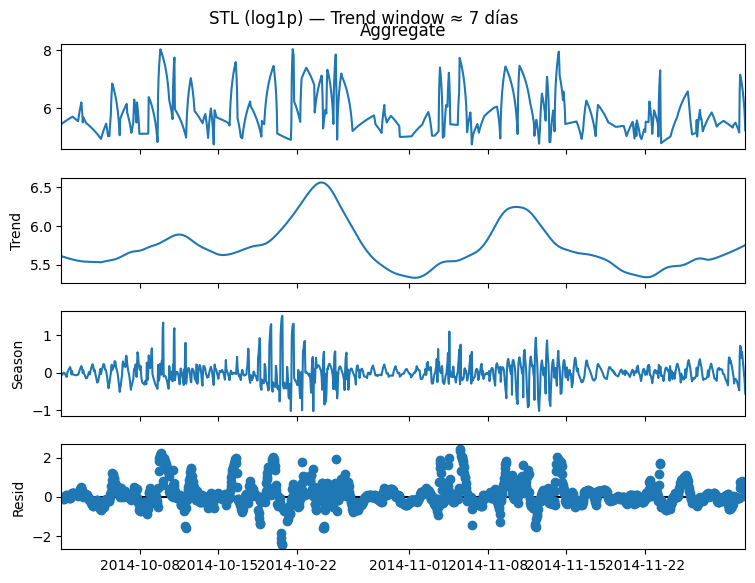

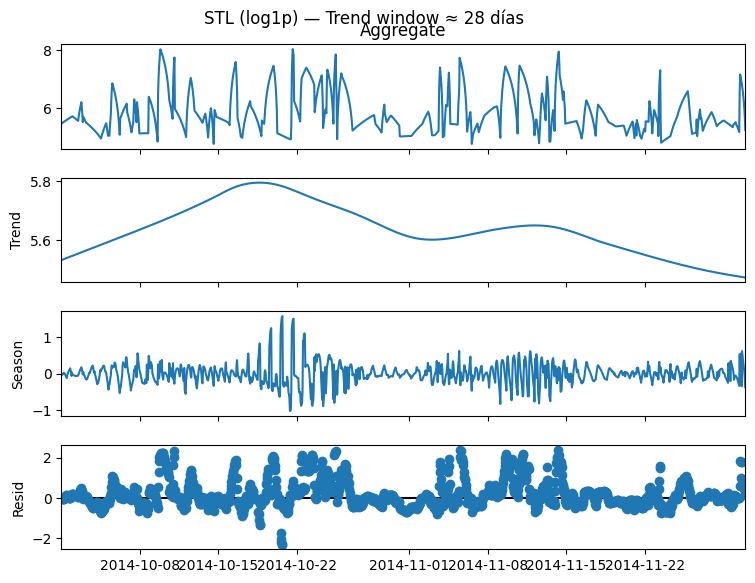

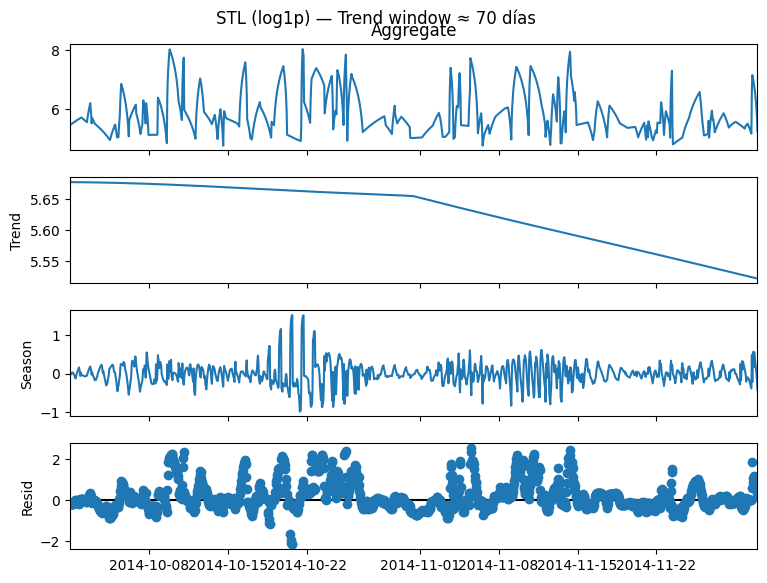


 ====================== HORIZONTE: 7 días ======================
[Linear]  MAE 172.79 | RMSE 255.76
[MLP]     MAE 175.92 | RMSE 223.51


DEBUG:cmdstanpy:input tempfile: /tmp/tmprqsk8e4s/qgr_017p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprqsk8e4s/wckr101q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6297', 'data', 'file=/tmp/tmprqsk8e4s/qgr_017p.json', 'init=/tmp/tmprqsk8e4s/wckr101q.json', 'output', 'file=/tmp/tmprqsk8e4s/prophet_modelddnbm4it/prophet_model-20250824230709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:07:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:07:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


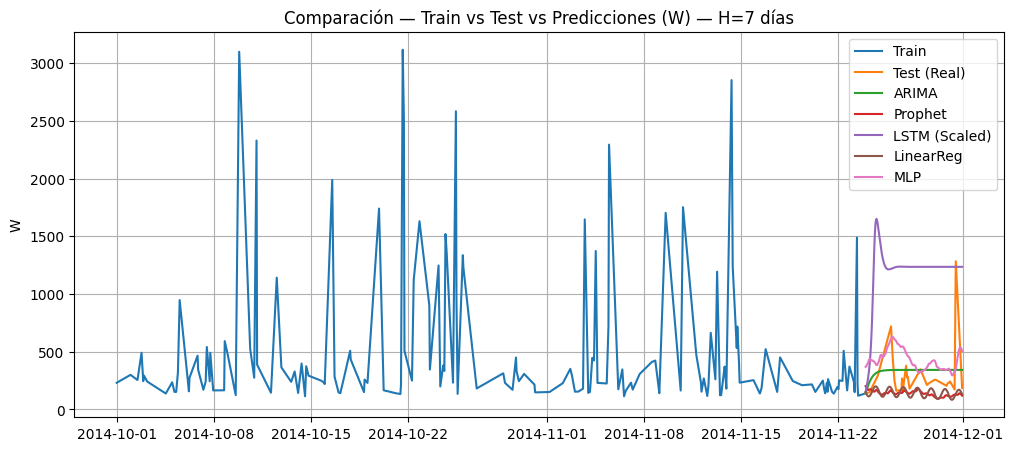


 ====================== HORIZONTE: 14 días ======================
[Linear]  MAE 157.08 | RMSE 206.61
[MLP]     MAE 125.62 | RMSE 176.01


DEBUG:cmdstanpy:input tempfile: /tmp/tmprqsk8e4s/533mrz__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprqsk8e4s/7uu7i029.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91953', 'data', 'file=/tmp/tmprqsk8e4s/533mrz__.json', 'init=/tmp/tmprqsk8e4s/7uu7i029.json', 'output', 'file=/tmp/tmprqsk8e4s/prophet_modelbzcwm00_/prophet_model-20250824230945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:09:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:09:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


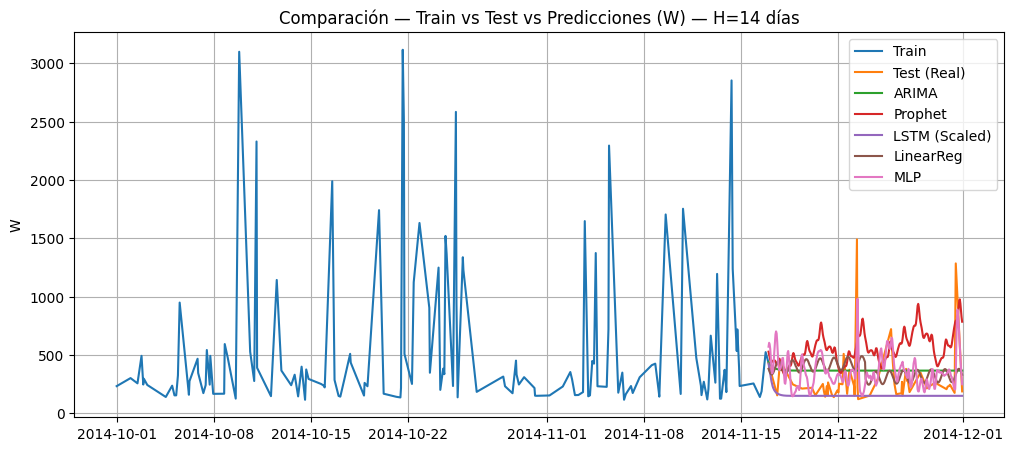


 ====================== HORIZONTE: 21 días ======================
[Linear]  MAE 410.55 | RMSE 542.37
[MLP]     MAE 181.29 | RMSE 275.52


DEBUG:cmdstanpy:input tempfile: /tmp/tmprqsk8e4s/acxmon_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprqsk8e4s/u7pfnccr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4302', 'data', 'file=/tmp/tmprqsk8e4s/acxmon_a.json', 'init=/tmp/tmprqsk8e4s/u7pfnccr.json', 'output', 'file=/tmp/tmprqsk8e4s/prophet_modelht4ohrqf/prophet_model-20250824231251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


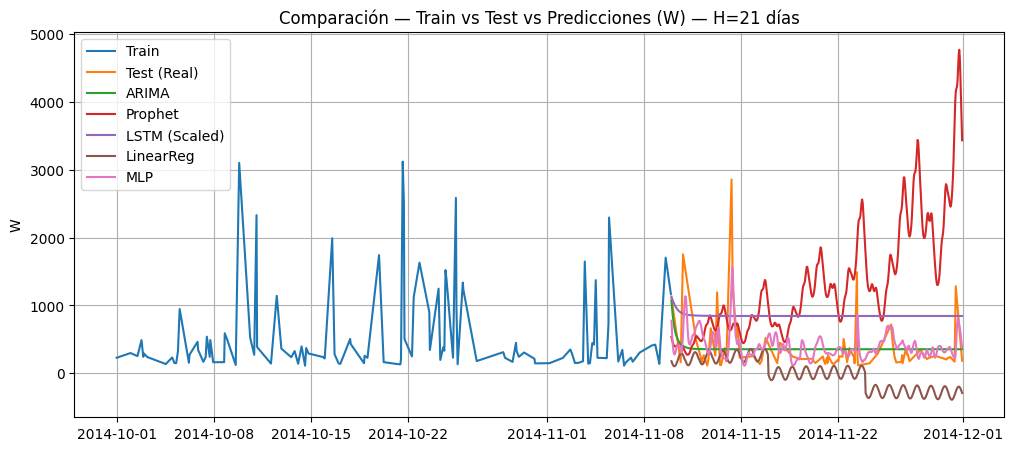

,H(days),Lin_MAE,Lin_RMSE,MLP_MAE,MLP_RMSE,ARIMA_MAE,ARIMA_RMSE,Prophet_MAE,Prophet_RMSE,LSTM_MAE,LSTM_RMSE
0,7,172.790185,255.755074,175.917562,223.512068,134.917264,190.129657,179.960426,263.783058,879.572434,923.704638
1,14,157.075976,206.607142,125.623385,176.006356,151.599368,192.757678,298.561782,338.721724,136.933975,222.614451
2,21,410.552462,542.371922,181.285031,275.521337,205.570948,344.778213,1096.094081,1372.421361,545.648641,578.877202


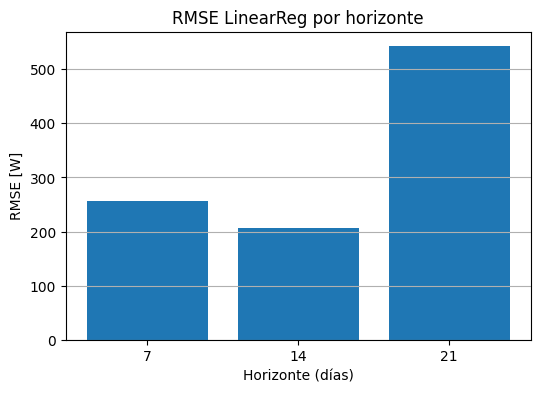

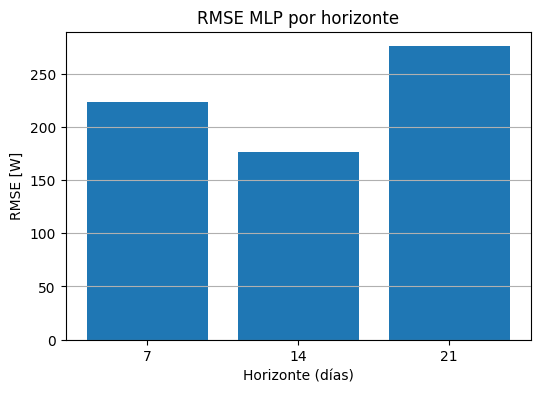

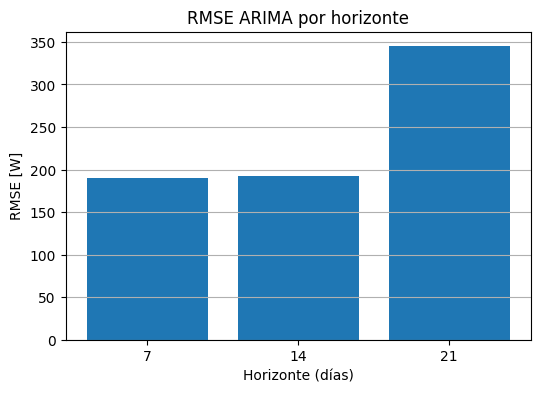

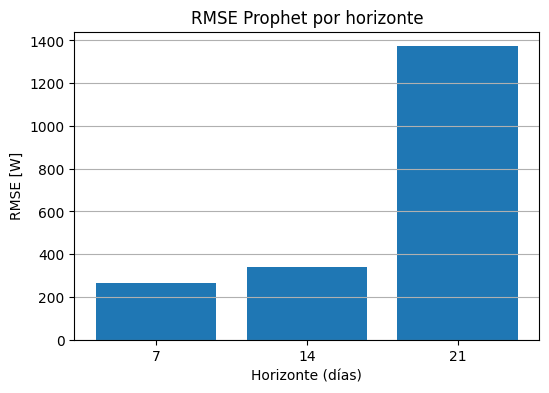

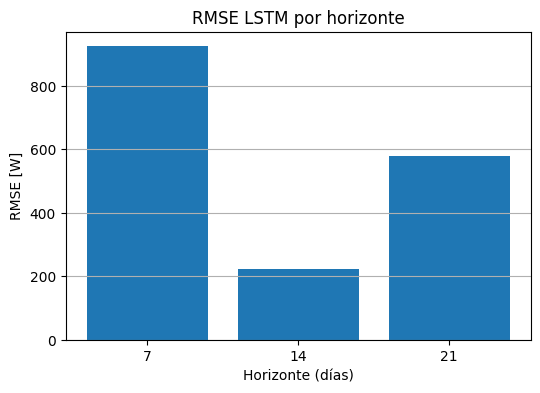

In [11]:
# Completa OK
# ================== EXPERIMENTOS MULTI-HORIZONTE: 7, 14, 21 días ==================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LinearRegression

def align_xy(idx, yhat):
    yhat = np.asarray(yhat); n = min(len(idx), len(yhat))
    return idx[-n:], yhat[-n:]

def make_supervised(arr, win=24):
    X,y=[],[]
    for i in range(len(arr)-win):
        X.append(arr[i:i+win]); y.append(arr[i+win])
    X=np.asarray(X); y=np.asarray(y)
    if X.ndim==2: X=X[:,:,None]
    return X,y

# --- Garantizar df_ts (serie horaria) ---
def _clean(s): return str(s).replace("\ufeff","").replace("\xa0"," ").strip()
if 'df_ts' not in globals():
    assert 'df' in globals() and isinstance(df, pd.DataFrame), "No hay df ni df_ts."
    d0 = df.copy(); d0.columns=[_clean(c) for c in d0.columns]
    if d0.index.name is not None and _clean(d0.index.name).lower() in {"time","fecha","datetime","timestamp","date"}:
        d0 = d0.reset_index()
    lower={c.lower():c for c in d0.columns}
    tcol = "Time" if "Time" in d0.columns else next((lower[k] for k in ["time","fecha","datetime","timestamp","date"] if k in lower), None)
    ycol = "Aggregate" if "Aggregate" in d0.columns else next((lower[k] for k in ["aggregate","consumo","consumption","energy","kwh"] if k in lower), None)
    d0 = d0[[tcol,ycol]].rename(columns={tcol:"Time", ycol:"Aggregate"})
    d0["Time"]=pd.to_datetime(d0["Time"], errors="coerce", infer_datetime_format=True)
    d0=d0.dropna(subset=["Time"]).sort_values("Time").set_index("Time")
    ser = pd.to_numeric(d0["Aggregate"], errors="coerce").asfreq("H")
    ser = ser.interpolate("time").bfill().ffill()
    df_ts = ser.to_frame(name="Aggregate")

print("Rango temporal:", df_ts.index.min(), "→", df_ts.index.max(), "| filas:", len(df_ts))

# --- STL diagnóstico (log1p) ---
for days in [7, 28, 70]:
    STL(np.log1p(df_ts["Aggregate"]), period=24, trend=days*24+1, robust=True).fit().plot()
    plt.gcf().set_size_inches(8,6); plt.suptitle(f"STL (log1p) — Trend window ≈ {days} días"); plt.show()

H_LIST = [7, 14, 21]   # días de test a evaluar
WIN_DEFAULT = 168      # ventana LSTM por defecto (1 semana)

results = []  # para tabla de métricas final

for H in H_LIST:
    print("\n", "="*22, f"HORIZONTE: {H} días", "="*22)
    H_hours = 24*H

    series_raw = df_ts["Aggregate"].astype(float)
    if len(series_raw) <= H_hours + 200:
        print(f"⚠️ Pocas filas para H={H}d; los resultados pueden ser débiles.")

    # --- Split común ---
    y_train_raw = series_raw.iloc[:-H_hours]
    y_test_raw  = series_raw.iloc[-H_hours:]

    # ================= REGRESIÓN LINEAL (features calendarias) =================
    work = pd.DataFrame({"Aggregate": series_raw})
    work["hora"] = work.index.hour
    work["dow"] = work.index.dayofweek
    work["dia_ano"] = work.index.dayofyear
    work["sin_hora"] = np.sin(2*np.pi*work["hora"]/24)
    work["cos_hora"] = np.cos(2*np.pi*work["hora"]/24)
    work["sin_dia"] = np.sin(2*np.pi*work["dia_ano"]/365)
    work["cos_dia"] = np.cos(2*np.pi*work["dia_ano"]/365)

    X = work[["sin_hora","cos_hora","sin_dia","cos_dia","dow"]].values
    y = work["Aggregate"].values
    X_tr, X_te = X[:-H_hours], X[-H_hours:]
    y_tr, y_te = y[:-H_hours], y[-H_hours:]

    lin = LinearRegression().fit(X_tr, y_tr)
    lin_pred = lin.predict(X_te)
    lin_mae = mean_absolute_error(y_te, lin_pred)
    lin_rmse = np.sqrt(mean_squared_error(y_te, lin_pred))
    print(f"[Linear]  MAE {lin_mae:.2f} | RMSE {lin_rmse:.2f}")

    # ================= MLP (ventana) =================
    # Ventana adaptativa: usa 72 si la historia es corta, sino 168
    win = min(WIN_DEFAULT, max(24*3, len(y_train_raw)//6))
    series_num = series_raw.values.astype(float)
    X_all, Y_all = [], []
    for i in range(len(series_num)-win):
        X_all.append(series_num[i:i+win]); Y_all.append(series_num[i+win])
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    cut = len(series_num) - H_hours - win
    Xtr_mlp, Xte_mlp = X_all[:cut], X_all[cut:]
    Ytr_mlp, Yte_mlp = Y_all[:cut], Y_all[cut:]

    # escalado de entradas (mejor estabilidad)
    sc_mlp = StandardScaler()
    Xtr_mlp_s = sc_mlp.fit_transform(Xtr_mlp)
    Xte_mlp_s = sc_mlp.transform(Xte_mlp)

    mlp = keras.Sequential([
        keras.layers.Input(shape=(win,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])
    mlp.compile(optimizer='adam', loss='mse')
    es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    _ = mlp.fit(Xtr_mlp_s, Ytr_mlp, validation_split=0.2, epochs=50, batch_size=64, callbacks=[es], verbose=0)
    mlp_pred = mlp.predict(Xte_mlp_s, verbose=0).ravel()
    mlp_mae = mean_absolute_error(Yte_mlp, mlp_pred)
    mlp_rmse = np.sqrt(mean_squared_error(Yte_mlp, mlp_pred))
    print(f"[MLP]     MAE {mlp_mae:.2f} | RMSE {mlp_rmse:.2f}")

    # ================= SERIES DE TIEMPO (log1p) =================
    y_train = np.log1p(y_train_raw)
    y_test  = np.log1p(y_test_raw)

    # --- ARIMA fallback por AIC si no hay pmdarima ---
    def arima_fallback_grid(y_tr, p_list=(0,1,2,3), d_list=(0,1), q_list=(0,1,2,3)):
        best = {"aic": np.inf, "order": None, "model": None}
        for p in p_list:
            for d in d_list:
                for q in q_list:
                    try:
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            m = ARIMA(y_tr, order=(p,d,q)).fit()
                        if m.aic < best["aic"]:
                            best = {"aic": m.aic, "order": (p,d,q), "model": m}
                    except Exception:
                        continue
        if best["model"] is None:
            raise RuntimeError("ARIMA grid falló.")
        return best

    best = arima_fallback_grid(y_train)
    fc_arima = best["model"].forecast(steps=len(y_test))
    # Prophet
    m = Prophet(daily_seasonality=True, weekly_seasonality=True,
                yearly_seasonality=False, seasonality_mode='multiplicative')
    m.fit(pd.DataFrame({"ds": y_train.index, "y": y_train.values}))
    fc_prophet = m.predict(pd.DataFrame({"ds": y_test.index}))["yhat"].values

    # LSTM (recursivo) en log1p
    win_lstm = min(WIN_DEFAULT, max(24*3, len(y_train)//6))
    sc = StandardScaler()
    ytr_s = sc.fit_transform(y_train.values.reshape(-1,1)).ravel()

    Xtr_lstm, ytr_lstm = make_supervised(ytr_s, win_lstm)
    lstm = keras.Sequential([
        keras.layers.Input(shape=(win_lstm,1)),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.LSTM(32),
        keras.layers.Dense(1)
    ])
    lstm.compile(optimizer='adam', loss='mse')
    es2 = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    _ = lstm.fit(Xtr_lstm, ytr_lstm, validation_split=0.2, epochs=50, batch_size=32, callbacks=[es2], verbose=0)

    # Predicción recursiva
    hist_vals_s = ytr_s[-win_lstm:].tolist()
    preds_s = []
    for _ in range(len(y_test)):
        x = np.array(hist_vals_s[-win_lstm:])[None,:,None]
        p = lstm.predict(x, verbose=0).ravel()[0]
        preds_s.append(p); hist_vals_s.append(p)
    preds_log = sc.inverse_transform(np.array(preds_s).reshape(-1,1)).ravel()

    # ---> Volver a W para comparar todo en la misma escala
    arima_kwh   = np.expm1(fc_arima)
    prophet_kwh = np.expm1(fc_prophet)
    lstm_kwh    = np.expm1(preds_log)

    # métricas en W
    xa, ya = align_xy(y_test_raw.index, arima_kwh)
    xp, yp = align_xy(y_test_raw.index, prophet_kwh)
    xl, yl = align_xy(y_test_raw.index, lstm_kwh)

    arima_mae = mean_absolute_error(y_test_raw.loc[xa], ya)
    arima_rmse= np.sqrt(mean_squared_error(y_test_raw.loc[xa], ya))
    prop_mae  = mean_absolute_error(y_test_raw.loc[xp], yp)
    prop_rmse = np.sqrt(mean_squared_error(y_test_raw.loc[xp], yp))
    lstm_mae  = mean_absolute_error(y_test_raw.loc[xl], yl)
    lstm_rmse = np.sqrt(mean_squared_error(y_test_raw.loc[xl], yl))

    results.append([H, lin_mae, lin_rmse, mlp_mae, mlp_rmse, arima_mae, arima_rmse, prop_mae, prop_rmse, lstm_mae, lstm_rmse])

    # ---------- Gráfico por horizonte (W) ----------
    plt.figure(figsize=(12,5))
    plt.plot(y_train_raw.index, y_train_raw.values, label="Train")
    plt.plot(y_test_raw.index,  y_test_raw.values,  label="Test (Real)")
    plt.plot(xa, ya, label="ARIMA")
    plt.plot(xp, yp, label="Prophet")
    plt.plot(xl, yl, label="LSTM (Scaled)")
    # MLP/Lineal se predicen en los mismos índices de test:
    plt.plot(y_test_raw.index, lin_pred, label="LinearReg")
    plt.plot(y_test_raw.index[-len(mlp_pred):], mlp_pred, label="MLP")
    plt.title(f"Comparación — Train vs Test vs Predicciones (W) — H={H} días")
    plt.ylabel("W"); plt.legend(); plt.grid(True); plt.show()

# ---------- Tabla final de métricas ----------
cols = ["H(days)","Lin_MAE","Lin_RMSE","MLP_MAE","MLP_RMSE","ARIMA_MAE","ARIMA_RMSE","Prophet_MAE","Prophet_RMSE","LSTM_MAE","LSTM_RMSE"]
metrics_df = pd.DataFrame(results, columns=cols)
display(metrics_df)

# Barras comparativas por modelo (RMSE) para cada horizonte
for model, col in [("LinearReg","Lin_RMSE"),("MLP","MLP_RMSE"),("ARIMA","ARIMA_RMSE"),("Prophet","Prophet_RMSE"),("LSTM","LSTM_RMSE")]:
    plt.figure(figsize=(6,4))
    plt.bar(metrics_df["H(days)"].astype(str), metrics_df[col])
    plt.title(f"RMSE {model} por horizonte"); plt.xlabel("Horizonte (días)"); plt.ylabel("RMSE [W]")
    plt.grid(True, axis="y"); plt.show()

/tmp/ipython-input-301662082.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y = y.asfreq('H').interpolate('time').bfill().ffill()
/tmp/ipython-input-301662082.py:59: RuntimeWarning: divide by zero encountered in divide
  periods_h = np.where(f>0, 1.0/f, np.inf)


Rango temporal: 2014-10-01 00:00:05 → 2014-11-30 23:00:05 | N=1464 muestras (freq=h)

=== Periodicidades detectadas (Welch) ===
period_h period_days     power
    42.0        1.75 2.259e+01
    84.0        3.50 4.129e+01


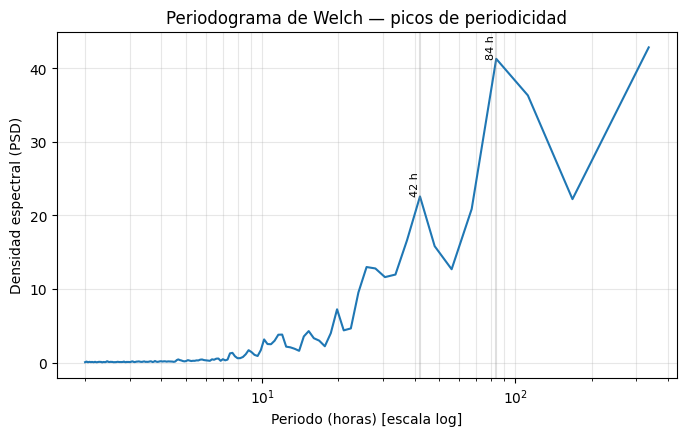

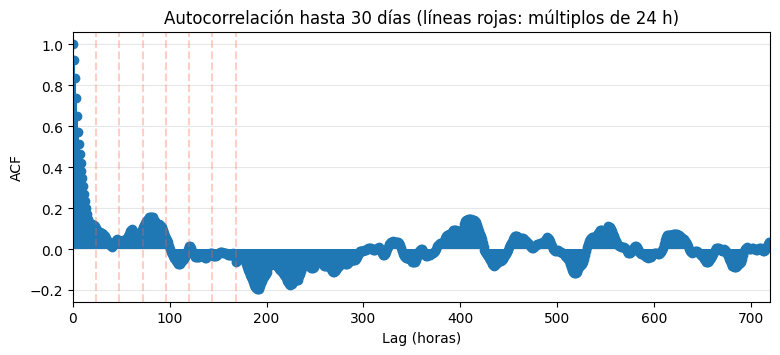


Fuerza estacional (STL): diaria=0.06 | semanal=0.14


In [12]:
# ============================================================
# Periodicidades con Periodograma de Welch (y confirmación ACF)
# Compatible con tu notebook (usa df_ts si existe; si no, crea desde df)
# ============================================================
import sys, subprocess, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
# deps (instala si faltan)
try:
    from scipy.signal import welch, find_peaks
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "scipy"])
    from scipy.signal import welch, find_peaks
try:
    from statsmodels.tsa.stattools import acf
    from statsmodels.tsa.seasonal import STL
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "statsmodels"])
    from statsmodels.tsa.stattools import acf
    from statsmodels.tsa.seasonal import STL

# ---------- 0) Garantizar la serie horaria 'y' (1 dato por hora) ----------
def _clean(s): return str(s).replace("\ufeff","").replace("\xa0"," ").strip()

if 'df_ts' in globals() and isinstance(df_ts, pd.DataFrame):
    y = pd.to_numeric(df_ts['Aggregate'], errors='coerce')
    y = y.asfreq('H').interpolate('time').bfill().ffill()
else:
    assert 'df' in globals(), "No encuentro df_ts ni df. Carga antes tu CSV en 'df'."
    d0 = df.copy()
    d0.columns = [_clean(c) for c in d0.columns]
    # si Time está en el índice, pasarlo a columna
    if d0.index.name is not None and _clean(d0.index.name).lower() in {"time","fecha","datetime","timestamp","date"}:
        d0 = d0.reset_index()
    lower = {c.lower(): c for c in d0.columns}
    tcol = "Time" if "Time" in d0.columns else next((lower[k] for k in ["time","fecha","datetime","timestamp","date"] if k in lower), None)
    ycol = "Aggregate" if "Aggregate" in d0.columns else next((lower[k] for k in ["aggregate","consumo","consumption","energy","kwh"] if k in lower), None)
    assert tcol and ycol, f"No encuentro columnas de tiempo/valor en df. Columnas: {list(d0.columns)}"
    d0 = d0[[tcol, ycol]].rename(columns={tcol:"Time", ycol:"Aggregate"})
    d0["Time"] = pd.to_datetime(d0["Time"], errors="coerce", infer_datetime_format=True)
    d0 = d0.dropna(subset=["Time"]).sort_values("Time").set_index("Time")
    y = pd.to_numeric(d0["Aggregate"], errors='coerce').asfreq('H').interpolate('time').bfill().ffill()

print(f"Rango temporal: {y.index.min()} → {y.index.max()} | N={len(y)} muestras (freq={y.index.freqstr})")

# ---------- 1) Preproceso suave: estabilizar picos (opcional) ----------
# Para hogares conviene log1p para que los picos no dominen el espectro.
y_log = np.log1p(y - y.min() + 1)

# ---------- 2) Welch: PSD vs frecuencia (ciclos/hora) ----------
fs = 1.0  # 1 muestra por hora
NPERSEG_DAYS = 14
nperseg = min(len(y_log), 24*NPERSEG_DAYS)          # ventana de ~14 días
noverlap = int(0.5*nperseg)                         # 50% solape
f, Pxx = welch(y_log.values, fs=fs, window='hann',
               nperseg=nperseg, noverlap=noverlap,
               detrend='constant', scaling='density')

# Convertir a periodo (horas) y filtrar rangos útiles
periods_h = np.where(f>0, 1.0/f, np.inf)
mask = (periods_h >= 2) & (periods_h <= 24*30)      # de 2 h a 30 días
periods_h = periods_h[mask]
Pxx_f = Pxx[mask]

# ---------- 3) Detectar picos principales ----------
# Umbral por prominencia para picos "reales"
prom = np.percentile(Pxx_f, 90)
peaks, _ = find_peaks(Pxx_f, prominence=prom)
# Top K por potencia
K = 8
order = np.argsort(Pxx_f[peaks])[::-1][:K]
pk_periods = periods_h[peaks][order]
pk_power   = Pxx_f[peaks][order]
res = (pd.DataFrame({"period_h": pk_periods,
                     "period_days": pk_periods/24.0,
                     "power": pk_power})
         .sort_values("period_h"))
# Deduplicar cercanos (p.ej., 23.9 vs 24.2 h)
res["period_h_round"] = res["period_h"].round(1)
res = res.drop_duplicates("period_h_round").drop(columns="period_h_round")

print("\n=== Periodicidades detectadas (Welch) ===")
print(res.to_string(index=False, formatters={
    "period_h":   "{:.1f}".format,
    "period_days":"{:.2f}".format,
    "power":      "{:.3e}".format
}))

# ---------- 4) Gráfico Periodograma (eje en periodos) ----------
plt.figure(figsize=(8,4.5))
# usar escala log-log en X para ver bien 24 h y 168 h
plt.semilogx(periods_h, Pxx_f)
for T, pwr in zip(res["period_h"].values, res["power"].values):
    if 2 <= T <= 24*30:
        plt.axvline(T, color='gray', alpha=0.25)
        plt.text(T, pwr, f"{T:.0f} h", rotation=90, va='bottom', ha='right', fontsize=8)
plt.xlabel("Periodo (horas) [escala log]")
plt.ylabel("Densidad espectral (PSD)")
plt.title("Periodograma de Welch — picos de periodicidad")
plt.grid(True, which="both", axis="both", alpha=0.3)
plt.show()

# ---------- 5) ACF (confirmación visual) ----------
max_days = 30
nlags = min(len(y_log)-2, 24*max_days)
acf_vals = acf(y_log.values, nlags=nlags, fft=True)
lags = np.arange(len(acf_vals))
plt.figure(figsize=(9,3.5))
plt.stem(lags, acf_vals, basefmt=" ")
for L in [24, 48, 72, 96, 120, 144, 168]:
    if L <= nlags:
        plt.axvline(L, color='tomato', alpha=0.3, linestyle='--')
plt.xlim(0, nlags)
plt.xlabel("Lag (horas)")
plt.ylabel("ACF")
plt.title("Autocorrelación hasta 30 días (líneas rojas: múltiplos de 24 h)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# ---------- 6) Fuerza estacional (cuantificar) ----------
# Fuerza estacional (Hyndman): 1 - Var(resid) / Var(seasonal+resid)
def seasonal_strength(y_series, period):
    stl = STL(y_series, period=period, robust=True).fit()
    num = np.var(stl.resid, ddof=1)
    den = np.var(stl.seasonal + stl.resid, ddof=1)
    return max(0.0, 1.0 - (num/den))

Fs_day  = seasonal_strength(y_log, 24)
# quitar la parte diaria y medir semanal sobre el residuo de la primera STL
stl_day = STL(y_log, period=24, robust=True).fit()
Fs_week = seasonal_strength(y_log - stl_day.seasonal, 168)

print(f"\nFuerza estacional (STL): diaria={Fs_day:.2f} | semanal={Fs_week:.2f}")
